In [1]:
import openai
import tqdm
import json
import time
import re
import math
import os
import random
import datasets
import nltk
import torch
import json
import difflib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_metric
from IPython.display import display,HTML
from datasets import load_dataset, load_metric, concatenate_datasets
from sklearn.metrics import cohen_kappa_score
from tqdm.auto import tqdm
from collections import Counter
from transformers import AutoTokenizer
from nltk import word_tokenize

In [2]:
sbdh_map_dict = { # 12 final sbdh categories
    'job insecurity': 'financial insecurity',
    'substance abuse': 'substance abuse',
    'social isolation': 'isolation or loss of relationship',
    'psychiatric symptoms or disorders': 'psychiatric symptoms or disorders',
    'housing insecurity': 'housing insecurity',
    'financial insecurity': 'financial insecurity',
    'patient disability': 'patient disability',
    'pain': 'pain',
    'loss of relationship': 'isolation or loss of relationship',
    'transitions of care': 'transitions of care',
    'food insecurity': 'food insecurity',
    'violence': 'violence',
    'barriers to care': 'barriers to care',
    'legal problems': 'legal problems',
    'physical isolation': 'isolation or loss of relationship'
}

sbdh_types = [
    'Job Insecurity', 'Substance Abuse', 'Social Isolation', 'Psychiatric Symptoms or Disorders', 'Housing Insecurity', 'Financial Insecurity', 
    'Patient Disability', 'Pain', 'Loss of Relationship', 'Transitions of Care', 'Food Insecurity', 'Violence', 'Barriers to Care', 'Legal Problems', 'Physical Isolation'
]

# V1

In [65]:
openai.api_key = '' # INSERT YOUR API KEY

In [66]:
model_name = "gpt-4-0613" # "gpt-4-0314"
temperature = 0
client = openai.OpenAI(api_key=openai.api_key)

In [159]:
with open('prompts/examples.txt') as f: 
    examples = f.readlines()

example_dict_list = []
temp_dict = {}
for idx,i in enumerate(examples):
    if i!='\n':
        temp_dict[i.split(': ')[0].strip()] = ' '.join(i.split(': ')[1:]).strip()
    if len(temp_dict)==3: 
        example_dict_list += [temp_dict]
        temp_dict = {}

examples_df = pd.DataFrame(example_dict_list)
examples_df['Textspan'] = examples_df.apply(lambda x: ' || '.join([i.split(', ')[0][1:] for i in x['Annotations'].split(' || ')]), axis=1)
examples_df['SBDH'] = examples_df.apply(lambda x: ' || '.join([i.split(', ')[1] for i in x['Annotations'].split(' || ')]), axis=1)
examples_df['Presence'] = examples_df.apply(lambda x: ' || '.join([i.split(', ')[2] for i in x['Annotations'].split(' || ')]), axis=1)
examples_df['Period'] = examples_df.apply(lambda x: ' || '.join([i.split(', ')[3][:-1] for i in x['Annotations'].split(' || ')]), axis=1)

In [118]:
# check if annotations are in correct format
anns = []
for ann in examples_df['Annotations'].tolist():
    # print([len(i.split(', ')) for i in ann.split(' || ')])
    anns+=[i.split(', ')[1] for i in ann.split(' || ')]
print(Counter(anns))

Counter({'Housing Insecurity': 15, 'Psychiatric Symptoms or Disorders': 10, 'Financial Insecurity': 9, 'Substance Abuse': 9, 'Transitions of Care': 9, 'Violence': 8, 'Job Insecurity': 8, 'Legal Problems': 7, 'Social Isolation': 7, 'Loss of Relationship': 6, 'Food Insecurity': 5, 'Pain': 4, 'Barriers to Care': 3, 'Patient Disability': 3, 'Physical Isolation': 2})


In [119]:
examples_df.sample(n=10, random_state=0)

,Text,Thought processes,Annotations,Textspan,SBDH,Presence,Period
30,Unemployed but reported is seeking work.,Patient is currently unemployed || Patient is ...,"(unemployed, Job Insecurity, yes, current) || ...",unemployed || seeking work,Job Insecurity || Job Insecurity,yes || yes,current || current
37,Patient's Seroquel dose remains the same.,"Seroquel dosage did not change, so no transiti...","(does remains the same, Transitions of Care, n...",does remains the same,Transitions of Care,no,current
27,Admitting diagnoses/problems: abdominal pain.,Patient has abdominal pain.,"(pain, Pain, yes, current)",pain,Pain,yes,current
4,She is keeping herself busy attending church a...,"She attends church, where she is with others. ...","(attending church, Social Isolation, no, curre...",attending church || individuals who are suppor...,Social Isolation || Social Isolation,no || no,current || current
10,Patient says she was incarcerated for parole v...,Patient was incarcerated for a violation of th...,"(incarcerated, Legal Problems, yes, history) |...",incarcerated || parole violation || armed robb...,Legal Problems || Legal Problems || Legal Prob...,yes || yes || yes,history || history || history
25,Veteran is reporting unwanted thoughts of harm...,Thoughts of harming others is considered viole...,"(thoughts of harming, Violence, yes, current) ...",thoughts of harming || jumped me,Violence || Violence,yes || yes,current || current
28,Veteran no longer requires a walker for ambula...,Not requiring assistive devices shows that pat...,"(walker, Patient Disability, no, current)",walker,Patient Disability,no,current
11,"Is the patient ""marginally housed""? No. Has pa...","Patient is not currently ""marginally housed"". ...","(marginally housed, Housing Insecurity, no, cu...",marginally housed || homeless,Housing Insecurity || Housing Insecurity,no || no,current || current
38,Patient's pain has been addressed by patient's...,Patient is experiencing pain. || Patient's pai...,"(pain, Pain, yes, current) || (pain, Pain, yes...",pain || pain,Pain || Pain,yes || yes,current || current
31,Veteran was evicted from his most recent apart...,Eviction is categorized as housing insecurity....,"(was evicted, Housing Insecurity, yes, current...",was evicted || most recent apartment || non-pa...,Housing Insecurity || Housing Insecurity || Ho...,yes || yes || yes || yes || yes,current || current || current || current || cu...


## All in One

In [837]:
def encode_prompt(sample_example_df):
    """Encode multiple prompt instructions into a single string."""
    prompt = ''
    for idx in range(sample_example_df.shape[0]):
        prompt += f"Example {idx+1}.\n"
        prompt += f"Text: {sample_example_df.iloc[idx]['Text']}\n"
        prompt += f"Textspan: {sample_example_df.iloc[idx]['Textspan']}\n"
        prompt += f"Reasoning: {sample_example_df.iloc[idx]['Thought processes']}\n"
        prompt += f"SBDH: {sample_example_df.iloc[idx]['SBDH']}\n"
        prompt += f"Presence: {sample_example_df.iloc[idx]['Presence']}\n"
        prompt += f"Period: {sample_example_df.iloc[idx]['Period']}\n\n"
    return prompt.strip()

prompt_system = 'You are an expert in healthcare science and clinical text. Respond to user questions wisely.'
with open('prompts/sdoh_prompt.txt') as f: prompt_user = f.read()
prompt_suffix = """Format examples as a valid JSON with the following structure:
[
    {
        'Text':..., 
        'Annotations': [
            {
                'Textspan':...,
                'Reasoning':...,
                'SBDH':...,
                'Presence':...,
                'Period':...,
            },
            ...
        ]
    },
    {
        'Text':...,
        'Annotations': [
            {
                'Textspan':...,
                'Reasoning':...,
                'SBDH':...,
                'Presence':...,
                'Period':...,
            },
            ...
        ]
    },
    ...
]
"""

synth_sbdh_data, invalid_synth_sbdh_data, prompts = [], [], []
start_time = time.time()
num_few_shot_examples, num_examples_to_gen_at_once, num_examples_to_generate = 10, 10, 6000
# i = 0
for i in tqdm(range(num_examples_to_generate//num_examples_to_gen_at_once+2)):
    final_prompt = prompt_user.strip().replace('{##examples##}',encode_prompt(examples_df.sample(n=num_few_shot_examples,random_state=i)))\
    .replace('{##example_no##}',str(num_examples_to_gen_at_once))+' '+prompt_suffix
    prompts += [final_prompt]
    messages = [{"role": "system", "content": prompt_system},
                {"role": "user", "content": final_prompt}]
    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=.8,
        # response_format={"type": "json_object"}
    )
    gen_txt = response.choices[0].message.content
    gen_txt = re.sub("(?<=[a-z])'(?=[a-z])", "\\'",gen_txt) # Add escape character before apostrophes to avoid formatting error
    try:synth_sbdh_data += json.loads(json.dumps(eval(gen_txt)))
    except: 
        invalid_synth_sbdh_data += [gen_txt]
        print('Invalid JSON format.')
    
    # i += 1
    # print(f'Iteration: {i}, elapsed time: {(time.time()-start_time)/60} minutes, generated examples: {len(synth_sbdh_data)}')
    print(f'Generated examples: {len(synth_sbdh_data)}',end='\r')
    
    with open('synth_data_gpt4/synth_data_aio_4.json','w') as f:
        json.dump(synth_sbdh_data, f)
        
    if len(synth_sbdh_data)>=num_examples_to_generate: break

  0%|          | 0/602 [00:00<?, ?it/s]

Invalid JSON format.60
Invalid JSON format.1691
Invalid JSON format.4563
Invalid JSON format.5313


In [428]:
# Load synthetic data
synth_data = []
for i in range(1,5):    
    with open(f'synth_data_gpt4/synth_data_aio_{i}.json') as f:
        synth_data += json.load(f)

# Filter out examples with ill-formatted annotations
sents, anns = [], []
for idx,i in enumerate(synth_data):
    for ann in i['Annotations']:
        ann['Text']=i['Text'] 
        ann['idx']=idx
    sents += [i['Text']]
    anns += i['Annotations']

# print(f'Total examples: {len(sents)}, total annotations: {len(anns)}')
anns_df = pd.DataFrame(anns)

# stats (before)
print(f"Before >> \nExamples: {anns_df['idx'].nunique():,} || annotations: {anns_df.shape[0]:,} || ann/exmpales: {anns_df.shape[0]/anns_df['idx'].nunique():.2f}")
text_length = [len(sent.split(' ')) for sent in sents]
print(f'Average text length: {sum(text_length)/len(text_length):.2f} words')
print(f"Average textspan length: {anns_df['Textspan'].apply(lambda x: len(x.split(' '))).mean():.2f} words")

# Filter out ill-formatted examples
sbdh_types = list(map(str.lower,sbdh_types))
anns_df['SBDH'] = anns_df['SBDH'].astype(str).str.lower()
anns_df['Presence'] = anns_df['Presence'].astype(str).str.lower()
anns_df['Period'] = anns_df['Period'].astype(str).str.lower()
anns_df = anns_df[anns_df['SBDH'].isin(sbdh_types) & anns_df['Presence'].isin(['yes','no']) & anns_df['Period'].isin(['current','history'])]
anns_df = anns_df[anns_df.apply(lambda x: x['Textspan'] in x['Text'],axis=1)]

# merge annotations into single row
anns_df_collapsed = pd.DataFrame(anns_df['idx'].unique(),columns=['idx']).copy()
for col in ['Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period', 'Text']: 
    anns_df_collapsed[col] = 0
    
for i,idx in tqdm(enumerate(anns_df['idx'].unique()),total=anns_df_collapsed.shape[0]):
    temp_df = anns_df[anns_df['idx']==idx].copy()
    assert temp_df['Text'].nunique()==1
    for col in ['Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period']:
        anns_df_collapsed.loc[i,col] = ' || '.join(temp_df[col].tolist())
    anns_df_collapsed.loc[i,'Text'] = temp_df.iloc[0]['Text']

# stats (after)
print(f"After >> \nExamples: {anns_df['idx'].nunique():,} || annotations: {anns_df.shape[0]:,} || ann/exmpales: {anns_df.shape[0]/anns_df['idx'].nunique():.2f}")
print(f"Average text length: {anns_df_collapsed['Text'].apply(lambda x: len(x.split(' '))).mean():.2f} words")
print(f"Average textspan length: {anns_df['Textspan'].apply(lambda x: len(x.split(' '))).mean():.2f} words")

print(anns_df[['SBDH']].value_counts())
# print(anns_df[['Presence']].value_counts())
# print(anns_df[['Period']].value_counts())
print(anns_df[['Presence','Period']].value_counts())

Before >> 
Examples: 14,244 || annotations: 22,459 || ann/exmpales: 1.58
Average text length: 13.27 words
Average textspan length: 4.06 words


  0%|          | 0/13554 [00:00<?, ?it/s]

After >> 
Examples: 13,554 || annotations: 21,661 || ann/exmpales: 1.60
Average text length: 13.26 words
Average textspan length: 3.93 words
SBDH                             
job insecurity                       2256
substance abuse                      2130
social isolation                     2008
psychiatric symptoms or disorders    1941
housing insecurity                   1834
financial insecurity                 1673
patient disability                   1514
pain                                 1446
loss of relationship                 1334
transitions of care                  1311
food insecurity                      1029
violence                              985
barriers to care                      862
legal problems                        760
physical isolation                    578
dtype: int64
Presence  Period 
yes       current    18547
          history     2477
no        current      521
          history      116
dtype: int64


In [8]:
display(anns_df.head())
display(anns_df_collapsed.head())

,Textspan,Reasoning,SBDH,Presence,Period,Text,idx
0,mother recently passed away,Patient has lost a close relationship due to d...,loss of relationship,yes,current,"Patient's mother recently passed away, causing...",0
1,emotional distress,The patient is experiencing emotional difficul...,psychiatric symptoms or disorders,yes,current,"Patient's mother recently passed away, causing...",0
2,back pain,The patient is experiencing physical discomfort.,pain,yes,current,Veteran continues to have back pain and has be...,1
3,prescribed opioids,The patient has been provided with prescriptio...,substance abuse,yes,current,Veteran continues to have back pain and has be...,1
4,lives alone,The patient is living without companionship or...,social isolation,yes,current,Patient lives alone in a high-crime neighborho...,2


,idx,Textspan,Reasoning,SBDH,Presence,Period,Text
0,0,mother recently passed away || emotional distress,Patient has lost a close relationship due to d...,loss of relationship || psychiatric symptoms o...,yes || yes,current || current,"Patient's mother recently passed away, causing..."
1,1,back pain || prescribed opioids,The patient is experiencing physical discomfor...,pain || substance abuse,yes || yes,current || current,Veteran continues to have back pain and has be...
2,2,lives alone || high-crime neighborhood,The patient is living without companionship or...,social isolation || violence,yes || yes,current || current,Patient lives alone in a high-crime neighborho...
3,3,was laid off || struggling to pay for medical ...,"The patient has lost their job, indicating job...",job insecurity || financial insecurity,yes || yes,current || current,Patient was laid off and is now struggling to ...
4,4,difficulty in accessing fresh produce,"Patient lacks access to fresh, healthy food, i...",food insecurity,yes,current,Patient reports difficulty in accessing fresh ...


In [9]:
# check for similar looking sentences
rouge = load_metric("rouge")
results, eligible_idxs = [], []
sents = anns_df_collapsed['Text'].tolist()
for idx,sent in tqdm(enumerate(sents),total=len(sents)):
    res = rouge.compute(predictions=[sent]*len(sents[:idx+1]),references=sents[:idx+1],use_aggregator=False)
    res = [i.fmeasure for i in res['rougeL']]
    results += [res]
    
    r = res[:] # deep copy
    del r[idx] # delete rouge score with the sentence itself
    if idx ==0 or max(r)<0.7: eligible_idxs += [idx] 

results = np.array(results)
print(results.shape,len(eligible_idxs))

/home/avijit/miniconda3/envs/lt/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


  0%|          | 0/13554 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(13554,) 8767


In [338]:
with open("eligible_idxs.json", "w") as fp:
    json.dump(eligible_idxs, fp)

In [10]:
synth_sbdh_data_filtered = []
for i in eligible_idxs:
    synth_sbdh_data_filtered += [synth_data[anns_df_collapsed.loc[i,'idx']]]
print(len(synth_sbdh_data_filtered))

with open('synth_data_gpt4/synth_data_aio_filtered_8767.json','w') as f:
    json.dump(synth_sbdh_data_filtered, f)

8767


### Stats

In [11]:
with open('synth_data_gpt4/synth_data_aio_filtered_8767.json') as f:
    synth_sbdh_data_filtered = json.load(f)
print(len(synth_sbdh_data_filtered))

num_train_examples = int(len(synth_sbdh_data_filtered)*.7)
num_val_examples = int(len(synth_sbdh_data_filtered)*.1)
num_test_examples = len(synth_sbdh_data_filtered) - num_train_examples - num_val_examples
print(f"Training examples: {num_train_examples:,}, val examples: {num_val_examples:,}, test examples: {num_test_examples:,}")

random.seed(0)
random.shuffle(synth_sbdh_data_filtered)
sents, anns = [], []
for idx,i in enumerate(synth_sbdh_data_filtered):
    sents += [i['Text']]
    for ann_idx,_ in enumerate(i['Annotations']):
        ann = i['Annotations'][ann_idx].copy()
        ann['ex_no'] = idx
        ann['ann_no'] = ann_idx
        anns += [ann]
print(f'Total examples: {len(sents):,}; total annotations: {len(anns):,}')
anns_df = pd.DataFrame(anns)

# Filter out ill-formatted examples, there SHOULDN'T BE ANY SUCH DATA here. Something happened while savig 'synth_data_aio_filtered_8767.json'
sbdh_types = list(map(str.lower,sbdh_types))
anns_df['SBDH'] = anns_df['SBDH'].astype(str).str.lower()
anns_df['Presence'] = anns_df['Presence'].astype(str).str.lower()
anns_df['Period'] = anns_df['Period'].astype(str).str.lower()
# anns_df['Correct'] = anns_df['Correct'].astype(str).str.lower()
anns_df = anns_df[anns_df['SBDH'].isin(sbdh_types) & anns_df['Presence'].isin(['yes','no']) & anns_df['Period'].isin(['current','history'])]
anns_df = anns_df[anns_df.apply(lambda x: x['Textspan'] in x['Text'],axis=1)]
print(f"Total examples: {anns_df['idx'].nunique():,}; total annotations: {anns_df.shape[0]:,}")

8767
Training examples: 6,136, val examples: 876, test examples: 1,755
Total examples: 8,767; total annotations: 14,420
Total examples: 8,767; total annotations: 14,342


In [12]:
# merge annotations of same text into single row
anns_df_collapsed = pd.DataFrame(anns_df['idx'].unique(),columns=['idx']).copy()
for col in ['ex_no','Text','Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period']: 
    anns_df_collapsed[col] = 0
    
for i,idx in tqdm(enumerate(anns_df['idx'].unique()),total=anns_df_collapsed.shape[0]):
    temp_df = anns_df[anns_df['idx']==idx].copy()
    assert temp_df['Text'].nunique()==1
    for col in ['Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period']:
        anns_df_collapsed.loc[i,col] = ' || '.join(temp_df[col].tolist())
    anns_df_collapsed.loc[i,'Text'] = temp_df.iloc[0]['Text']
    anns_df_collapsed.loc[i,'ex_no'] = temp_df.iloc[0]['ex_no']
    
# stats (after)
print(f"Examples: {anns_df['idx'].nunique():,} || annotations: {anns_df.shape[0]:,} || ann/exmpales: {anns_df.shape[0]/anns_df['idx'].nunique():.2f}")
print(f"Average text length: {anns_df_collapsed['Text'].apply(lambda x: len(x.split(' '))).mean():.2f} words")
print(f"Average textspan length: {anns_df['Textspan'].apply(lambda x: len(x.split(' '))).mean():.2f} words")

  0%|          | 0/8767 [00:00<?, ?it/s]

Examples: 8,767 || annotations: 14,342 || ann/exmpales: 1.64
Average text length: 13.70 words
Average textspan length: 3.96 words


In [13]:
anns_df_collapsed.head()

,idx,ex_no,Text,Textspan,Reasoning,SBDH,Presence,Period
0,10742,0,He has suffered from chronic pain for several ...,suffered from chronic pain || not addicted to ...,The patient is suffering from chronic pain. ||...,pain || substance abuse,yes || no,current || current
1,8855,1,Patient feels undervalued at work; fears losin...,fears losing job,"The patient expresses fear of job loss, indica...",job insecurity,yes,current
2,2046,2,Patient is worried about losing his job due to...,worried about losing his job,Patient expresses fear of job loss due to heal...,job insecurity,yes,current
3,6082,3,The patient was attacked by a stranger on her ...,attacked by a stranger,The patient has been a victim of violence.,violence,yes,current
4,8862,4,He's been skipping meals to save up for his ki...,skipping meals || save up for his kid's tuition,Skipping meals can be a sign of food insecurit...,food insecurity || financial insecurity,yes || yes,current || current


In [16]:
# sbdh annotation distribution || train and val sets
sbdh_list = []
for sbdh in anns_df_collapsed.iloc[:num_train_examples]['SBDH'].tolist():
    sbdh_list += sbdh.split(' || ')
print(Counter(sbdh_list),len(sbdh_list))
sbdh_list = []
for sbdh in anns_df_collapsed.iloc[num_train_examples:num_train_examples+num_val_examples]['SBDH'].tolist():
    sbdh_list += sbdh.split(' || ')
print(Counter(sbdh_list),len(sbdh_list))
sbdh_list = []
# for sbdh in anns_df_collapsed.iloc[-num_test_examples:]['SBDH'].tolist():
#     sbdh_list += sbdh.split(' || ')
# print(Counter(sbdh_list),len(sbdh_list))

# sbdh distribution || test set, before human correction, for table 11; we report correction stats on table 13
raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_raelene_adj_v2.csv',encoding='UTF-8')
raelene_ann['exmpl_ann_no'] = raelene_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_emily_adj_v2.csv',encoding='UTF-8')
emily_ann['exmpl_ann_no'] = emily_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
df = pd.concat([
    emily_ann.copy(),
    raelene_ann[raelene_ann['exmpl_no']>=1000].copy()
], ignore_index=True, sort=False)
df['SBDH'] = df['SBDH'].apply(lambda x: x.lower())
print(df[df['Annotator']=='GPT-4']['SBDH'].value_counts().to_dict())

Counter({'psychiatric symptoms or disorders': 1088, 'job insecurity': 1018, 'social isolation': 946, 'substance abuse': 842, 'financial insecurity': 817, 'housing insecurity': 696, 'loss of relationship': 664, 'pain': 625, 'transitions of care': 618, 'patient disability': 608, 'food insecurity': 519, 'violence': 502, 'barriers to care': 406, 'legal problems': 353, 'physical isolation': 320}) 10022
Counter({'social isolation': 159, 'substance abuse': 139, 'psychiatric symptoms or disorders': 135, 'job insecurity': 126, 'loss of relationship': 103, 'housing insecurity': 101, 'financial insecurity': 101, 'pain': 100, 'transitions of care': 82, 'food insecurity': 79, 'patient disability': 79, 'violence': 77, 'barriers to care': 60, 'legal problems': 56, 'physical isolation': 46}) 1443
{'psychiatric symptoms or disorders': 312, 'job insecurity': 303, 'social isolation': 281, 'substance abuse': 262, 'financial insecurity': 235, 'pain': 200, 'housing insecurity': 193, 'patient disability': 18

In [19]:
for sbdh in sbdh_types:
    tr_ids = anns_df['idx'].unique().tolist()[:num_train_examples]
    print(
        sbdh, '>>>>',
        dict(anns_df[(anns_df['idx'].isin(tr_ids))&(anns_df['SBDH']==sbdh)]['Presence'].value_counts()), 
        dict(anns_df[(anns_df['idx'].isin(tr_ids))&(anns_df['SBDH']==sbdh)]['Period'].value_counts()))
print('-'*50)
for sbdh in sbdh_types:
    val_ids = anns_df['idx'].unique().tolist()[num_train_examples:num_train_examples+num_val_examples]
    print(
        sbdh, '>>>>',
        dict(anns_df[(anns_df['idx'].isin(val_ids))&(anns_df['SBDH']==sbdh)]['Presence'].value_counts()), 
        dict(anns_df[(anns_df['idx'].isin(val_ids))&(anns_df['SBDH']==sbdh)]['Period'].value_counts()))
print('-'*50)
for sbdh in sbdh_types:
    print(
        sbdh, '>>>>',
        dict(df[(df['Annotator']=='GPT-4')&(df['SBDH']==sbdh)]['Presence'].value_counts()), 
        dict(df[(df['Annotator']=='GPT-4')&(df['SBDH']==sbdh)]['Period'].value_counts()))

job insecurity >>>> {'yes': 993, 'no': 25} {'current': 959, 'history': 59}
substance abuse >>>> {'yes': 717, 'no': 125} {'current': 581, 'history': 261}
social isolation >>>> {'yes': 923, 'no': 23} {'current': 942, 'history': 4}
psychiatric symptoms or disorders >>>> {'yes': 1082, 'no': 6} {'current': 1026, 'history': 62}
housing insecurity >>>> {'yes': 663, 'no': 33} {'current': 632, 'history': 64}
financial insecurity >>>> {'yes': 801, 'no': 16} {'current': 802, 'history': 15}
patient disability >>>> {'yes': 603, 'no': 5} {'current': 591, 'history': 17}
pain >>>> {'yes': 624, 'no': 1} {'current': 612, 'history': 13}
loss of relationship >>>> {'yes': 660, 'no': 4} {'current': 453, 'history': 211}
transitions of care >>>> {'yes': 613, 'no': 5} {'current': 559, 'history': 59}
food insecurity >>>> {'yes': 504, 'no': 15} {'current': 514, 'history': 5}
violence >>>> {'yes': 494, 'no': 8} {'history': 253, 'current': 249}
barriers to care >>>> {'yes': 387, 'no': 19} {'current': 404, 'history

In [32]:
# sbdh classification label distribution
with open('synth_data_gpt4/sbdh_gpt4_v3_multilabel_train.json') as f:
    display(pd.DataFrame(json.load(f)['data']).iloc[:,1:-2].sum(axis=0))
print('-'*50)
with open('synth_data_gpt4/sbdh_gpt4_v3_multilabel_valid.json') as f:
    display(pd.DataFrame(json.load(f)['data']).iloc[:,1:-2].sum(axis=0))
print('-'*50)
with open('synth_data_gpt4/sbdh_gpt4_v3_multilabel_test.json') as f:
    display(pd.DataFrame(json.load(f)['data']).iloc[:,1:-2].sum(axis=0))

label_barriers_to_care                      375
label_substance_abuse                       624
label_housing_insecurity                    602
label_patient_disability                    567
label_legal_problems                        315
label_food_insecurity                       488
label_transitions_of_care                   566
label_psychiatric_symptoms_or_disorders    1010
label_isolation_or_loss_of_relationship    1430
label_violence                              467
label_pain                                  615
label_financial_insecurity                 1437
dtype: int64

--------------------------------------------------


label_barriers_to_care                      51
label_substance_abuse                       90
label_housing_insecurity                    88
label_patient_disability                    76
label_legal_problems                        47
label_food_insecurity                       69
label_transitions_of_care                   73
label_psychiatric_symptoms_or_disorders    127
label_isolation_or_loss_of_relationship    228
label_violence                              73
label_pain                                  94
label_financial_insecurity                 190
dtype: int64

--------------------------------------------------


label_barriers_to_care                     100
label_substance_abuse                      195
label_housing_insecurity                   167
label_patient_disability                   169
label_legal_problems                       102
label_food_insecurity                      131
label_transitions_of_care                  138
label_psychiatric_symptoms_or_disorders    278
label_isolation_or_loss_of_relationship    406
label_violence                             139
label_pain                                 190
label_financial_insecurity                 424
dtype: int64

### Finalize Data

In [8]:
cols = ['ex_no', 'Text', 'Textspan', 'SBDH', 'Presence', 'Period', 'Reasoning']
anns_df_collapsed.iloc[:num_train_examples][cols].to_csv('synth_sbdh/synth_sbdh_train.csv',index=False)
anns_df_collapsed.iloc[num_train_examples:num_train_examples+num_val_examples][cols].to_csv('synth_sbdh/synth_sbdh_val.csv',index=False)
anns_df_collapsed.iloc[-num_test_examples:][cols].to_csv('synth_sbdh/synth_sbdh_test.csv',index=False)

In [23]:
df = pd.read_csv('human_eval/sbdh_gpt4_v3_test_cmbd_consolidated.csv')
df['ex_no'] = df['ex_no'].apply(lambda x:x+7012)
df = df[df['Operation']!='discard'][cols+['Operation']].copy()

anns_df_collapsed = pd.DataFrame(df['ex_no'].unique(),columns=['ex_no']).copy()
for col in ['Text', 'Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period', 'Operation']: 
    anns_df_collapsed[col] = 0
    
for i,idx in tqdm(enumerate(df['ex_no'].unique()),total=anns_df_collapsed.shape[0]):
    temp_df = df[df['ex_no']==idx].copy()
    assert temp_df['Text'].nunique()==1
    for col in ['Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period', 'Operation']:
        assert 'XXX' not in temp_df[col].tolist()
        anns_df_collapsed.loc[i,col] = ' || '.join(map(str.lower,temp_df[col].tolist()))
    anns_df_collapsed.loc[i,'Text'] = temp_df.iloc[0]['Text']

anns_df_collapsed = pd.DataFrame(anns_df_collapsed)
anns_df_collapsed.to_csv('synth_sbdh/synth_sbdh_test_reviewed.csv',index=False)
anns_df_collapsed

  0%|          | 0/1732 [00:00<?, ?it/s]

,ex_no,Text,Textspan,Reasoning,SBDH,Presence,Period,Operation
0,7012,His lower back pain has been worsening over th...,lower back pain,experiencing lower back pain is a sign of the ...,pain,yes,current,keep
1,7013,The patient has recently been laid off from hi...,recently been laid off || concern about his fi...,"the patient lost his job recently, indicating ...",job insecurity || financial insecurity,yes || yes,current || current,keep || keep
2,7014,Patient finds it difficult to travel to the cl...,difficult to travel to the clinic || lack of t...,difficulty in traveling to the clinic due to l...,barriers to care || barriers to care,yes || yes,current || current,keep || add
3,7015,Veteran is going through a divorce and his wif...,going through a divorce || wife moved out,divorce is considered a loss of a personal rel...,loss of relationship || loss of relationship,yes || yes,current || current,keep || add
4,7016,Patient suffers from anxiety and has been havi...,suffers from anxiety || frequent panic attacks,the patient has a psychiatric disorder - anxie...,psychiatric symptoms or disorders || psychiatr...,yes || yes,current || current,keep || keep
...,...,...,...,...,...,...,...,...
1727,8762,He was arrested for DUI last month and is now ...,arrested for dui || facing legal proceedings,arrest for a dui indicates a violation of law ...,legal problems || legal problems,yes || yes,current || current,keep || add
1728,8763,Patient has been living alone for the past few...,living alone || rarely goes out,living alone often leads to social isolation. ...,social isolation || social isolation,yes || yes,current || current,keep || correct
1729,8764,"The patient, who is wheelchair-bound, requires...",wheelchair-bound,being wheelchair-bound indicates a physical di...,patient disability,yes,current,keep
1730,8765,Patient has had frequent hospital admissions d...,frequent hospital admissions,frequent hospital admissions indicate transiti...,transitions of care,yes,unclear,correct


### Convert to BIO format (Presence=Yes)

In [429]:
with open("eligible_idxs.json") as fp:
    eligible_idxs = json.load(fp)

In [851]:
def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll))

    return results

bio_formatted_data = []
for row_id in tqdm(range(anns_df_collapsed.loc[eligible_idxs].shape[0])):
    temp_dict = {}
    text = word_tokenize(anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Text'])
    temp_dict['tokens'] = text
    text_sbdh_tags = ['O']*len(text)
    # text_presence_tags = ['O']*len(text)
    text_period_tags = ['O']*len(text)

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Presence'].split(' || ')
    period_tags = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Period'].split(' || ')
    
    all_sl_idxs = []
    for i,span in enumerate(anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Textspan'].split(' || ')):
        if presence_tags[i] == 'yes': # only consider presence=yes
            textspan = word_tokenize(span)
            sl_idxs = find_sub_list(textspan,text) 
            for idx in sl_idxs:
                if text_sbdh_tags[idx[0]:idx[1]] == ['O']*len(textspan): # only put labels if the tokens are already unlabeled; avoiding nested labels
                    text_sbdh_tags[idx[0]] = 'B-'+sbdh_tags[i]
                    text_sbdh_tags[idx[0]+1:idx[1]] = ['I-'+sbdh_tags[i]]*(len(textspan)-1)
                    # text_presence_tags[idx[0]] = 'B-'+presence_tags[i]
                    # text_presence_tags[idx[0]+1:idx[1]] = ['I-'+presence_tags[i]]*(len(textspan)-1)
                    text_period_tags[idx[0]] = 'B-'+period_tags[i]
                    text_period_tags[idx[0]+1:idx[1]] = ['I-'+period_tags[i]]*(len(textspan)-1)
                    all_sl_idxs += [idx]
    
    if len(all_sl_idxs)>1:
        for idx1, idx2 in zip(all_sl_idxs[:-1],all_sl_idxs[1:]):
            if set(range(*idx1)).intersection(set(range(*idx2))): 
                print(f'Testspan overlap found at {row_id}!')
                break
            
    # print(text)
    temp_dict['ner_tags'] = text_sbdh_tags
    # temp_dict['presence_tags'] = text_presence_tags
    temp_dict['period_tags'] = text_period_tags
    bio_formatted_data += [temp_dict]

# bio_formatted_data = {'data':bio_formatted_data}

  0%|          | 0/8767 [00:00<?, ?it/s]

In [854]:
print(bio_formatted_data[1])

{'tokens': ['Patient', 'feels', 'undervalued', 'at', 'work', ';', 'fears', 'losing', 'job', 'due', 'to', 'company', 'downsizing', '.'], 'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'B-financial_insecurity', 'I-financial_insecurity', 'I-financial_insecurity', 'O', 'O', 'O', 'O', 'O'], 'period_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'B-current', 'I-current', 'I-current', 'O', 'O', 'O', 'O', 'O']}


In [852]:
num_train_examples = int(len(bio_formatted_data)*.7)
num_val_examples = int(len(bio_formatted_data)*.1)
num_test_examples = len(bio_formatted_data) - num_train_examples - num_val_examples
print(num_train_examples, num_val_examples, num_test_examples)

random.seed(0)
random.shuffle(bio_formatted_data)
with open('synth_data_gpt4/synth_data_aio_BIO_train_v2.json','w') as f:
    json.dump({'data':bio_formatted_data[:num_train_examples]}, f)
with open('synth_data_gpt4/synth_data_aio_BIO_val_v2.json','w') as f:
    json.dump({'data':bio_formatted_data[num_train_examples:num_train_examples+num_val_examples]}, f)
with open('synth_data_gpt4/synth_data_aio_BIO_test_v2.json','w') as f:
    json.dump({'data':bio_formatted_data[-num_test_examples:]}, f)

6136 876 1755


In [18]:
# Merge train and test sets
with open('synth_data_gpt4/synth_data_aio_BIO_train_v2.json') as f:
    a = json.load(f)['data']
# with open('synth_data_gpt4/synth_data_aio_BIO_test_v2.json') as f:
#     b = json.load(f)['data']
with open('synth_data_gpt4/synth_data_aio_BIO_test_hr_v2.json') as f:
    b = json.load(f)['data']
with open('synth_data_gpt4/synth_data_aio_BIO_train&test_hr_v2.json','w') as f:
    json.dump({'data':a+b}, f)

### Convert to BIO format 

In [438]:
def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll))

    return results

bio_formatted_data = []
for row_id in tqdm(range(anns_df_collapsed.loc[eligible_idxs].shape[0])):
    temp_dict = {}
    text = word_tokenize(anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Text'])
    temp_dict['tokens'] = text
    text_sbdh_tags = ['O']*len(text)
    text_presence_tags = ['O']*len(text)
    text_period_tags = ['O']*len(text)

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Presence'].split(' || ')
    period_tags = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Period'].split(' || ')
    
    all_sl_idxs = []
    for i,span in enumerate(anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Textspan'].split(' || ')):
        textspan = word_tokenize(span)
        sl_idxs = find_sub_list(textspan,text) 
        for idx in sl_idxs:
            if text_sbdh_tags[idx[0]:idx[1]] == ['O']*len(textspan): # only put labels if the tokens are already unlabeled; avoiding nested labels
                text_sbdh_tags[idx[0]] = 'B-'+sbdh_tags[i]
                text_sbdh_tags[idx[0]+1:idx[1]] = ['I-'+sbdh_tags[i]]*(len(textspan)-1)
                text_presence_tags[idx[0]] = 'B-'+presence_tags[i]
                text_presence_tags[idx[0]+1:idx[1]] = ['I-'+presence_tags[i]]*(len(textspan)-1)
                text_period_tags[idx[0]] = 'B-'+period_tags[i]
                text_period_tags[idx[0]+1:idx[1]] = ['I-'+period_tags[i]]*(len(textspan)-1)
                all_sl_idxs += [idx]
    
    if len(all_sl_idxs)>1:
        for idx1, idx2 in zip(all_sl_idxs[:-1],all_sl_idxs[1:]):
            if set(range(*idx1)).intersection(set(range(*idx2))): 
                print(f'Testspan overlap found at {row_id}!')
                break
            
    # print(text)
    temp_dict['ner_tags'] = text_sbdh_tags
    temp_dict['presence_tags'] = text_presence_tags
    temp_dict['period_tags'] = text_period_tags
    bio_formatted_data += [temp_dict]

  0%|          | 0/8767 [00:00<?, ?it/s]

In [439]:
num_train_examples = int(len(bio_formatted_data)*.7)
num_val_examples = int(len(bio_formatted_data)*.1)
num_test_examples = len(bio_formatted_data) - num_train_examples - num_val_examples
print(num_train_examples, num_val_examples, num_test_examples)

random.seed(0)
random.shuffle(bio_formatted_data)
with open('synth_data_gpt4/synth_data_aio_BIO_wPresence_train_v3.json','w') as f:
    json.dump({'data':bio_formatted_data[:num_train_examples]}, f)
with open('synth_data_gpt4/synth_data_aio_BIO_wPresence_val_v3.json','w') as f:
    json.dump({'data':bio_formatted_data[num_train_examples:num_train_examples+num_val_examples]}, f)
with open('synth_data_gpt4/synth_data_aio_BIO_wPresence_test_v3.json','w') as f:
    json.dump({'data':bio_formatted_data[-num_test_examples:]}, f)

6136 876 1755


### Convert to DSS format

In [433]:
def is_nested(range1list:list, range2list:list, verbose=False):
    '''
    Find if there is an intersection between elements in range1list and range2list.
    '''
    if len(range1list)==0 or len(range2list)==0: return False
    for range2 in range2list:
        for range1 in range1list:
            if set(range(*range1)).intersection(set(range(*range2))):
                if verbose:print(range1,range2)
                return True
    return False
        
formatted_data = []
skip_count, total_ann_count = 0, 0
for row_id in tqdm(range(anns_df_collapsed.loc[eligible_idxs].shape[0])):
    temp_dict = {}
    temp_dict['text'] = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Text']

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = [i for i in anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Presence'].split(' || ')]
    period_tags = [i for i in anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Period'].split(' || ')]
    reasoning_tags = [i for i in anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Reasoning'].split(' || ')]
    # temp_dict['reasoning'] = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Reasoning'].replace(' || ',' ')
    sbdh_ann, period_ann, reasoning_ann = [], [], []
    
    textspan_indices = []
    for i,textspan in enumerate(anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Textspan'].split(' || ')):
        total_ann_count += 1
        if presence_tags[i] == 'yes': # only consider presence=yes
            sl_indices = find_sub_list(textspan,temp_dict['text'])
            if is_nested(textspan_indices,sl_indices): # check for nested annotations and skip if found any
                skip_count += 1
                continue 
            textspan_indices += sl_indices
            sbdh_ann += [textspan+' <'+sbdh_tags[i]+'>']
            period_ann += [textspan+' <'+period_tags[i]+'>']
            reasoning_ann += [reasoning_tags[i]]
    temp_dict['sbdh_ann'] = ', '.join(sbdh_ann)
    temp_dict['period_ann'] = ', '.join(period_ann)
    temp_dict['reasoning'] = ' '.join(reasoning_ann)
    formatted_data += [temp_dict]
    # if row_id==10: break
print(f'Skipped annotations: {skip_count}, out of {total_ann_count}')        

  0%|          | 0/8767 [00:00<?, ?it/s]

Skipped annotations: 99, out of 14342


In [434]:
# v3: corrected 'reasoning' field, v2 has erroneous (nested/presece=No) reasonings
num_train_examples = int(len(formatted_data)*.7)
num_val_examples = int(len(formatted_data)*.1)
num_test_examples = len(formatted_data) - num_train_examples - num_val_examples
print(num_train_examples, num_val_examples, num_test_examples)

random.seed(0)
random.shuffle(formatted_data)
with open('synth_data_gpt4/sbdh_gpt4_v3_train.json','w') as f:
    json.dump({'data':formatted_data[:num_train_examples]}, f)
with open('synth_data_gpt4/sbdh_gpt4_v3_valid.json','w') as f:
    json.dump({'data':formatted_data[num_train_examples:num_train_examples+num_val_examples]}, f)
with open('synth_data_gpt4/sbdh_gpt4_v3_test.json','w') as f:
    json.dump({'data':formatted_data[-num_test_examples:]}, f)

6136 876 1755


### Convert to MLC format

In [21]:
with open("eligible_idxs.json") as fp:
    eligible_idxs = json.load(fp)

In [436]:
formatted_data = []
total_ann_count = 0
for row_id in tqdm(range(anns_df_collapsed.loc[eligible_idxs].shape[0])):
    temp_dict = {}
    temp_dict['text'] = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Text']

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Presence'].split(' || ')
    # temp_dict['reasoning'] = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Reasoning'].replace(' || ',' ')
    reasoning_tags = anns_df_collapsed.loc[eligible_idxs].iloc[row_id]['Reasoning'].split(' || ')
    
    for sbdh in set(sbdh_map_dict.values()):
        temp_dict['label_'+sbdh.replace(' ','_')] = 0
    
    sbdh_ann, reasoning_ann, textspan_indices = [], [], []
    for i,_ in enumerate(presence_tags):
        total_ann_count += 1
        if presence_tags[i] == 'yes': # only consider presence=yes
            temp_dict['label_'+sbdh_tags[i]] = 1
            sbdh_ann += ['<'+sbdh_tags[i]+'>']
            reasoning_ann += [reasoning_tags[i]]
    temp_dict['sbdh_ann'] = ', '.join(set(sbdh_ann))
    temp_dict['reasoning'] = ' '.join(reasoning_ann)
    formatted_data += [temp_dict]
print(f'Total annotations: {total_ann_count}')   

  0%|          | 0/8767 [00:00<?, ?it/s]

Total annotations: 14342


In [47]:
formatted_data[1331]

{'text': 'His wife reports that he has been avoiding alcohol and drugs since his rehab.',
 'reasoning': "The patient's avoidance of alcohol and drugs post-rehab indicates an absence of substance abuse.",
 'label_barriers_to_care': 0,
 'label_substance_abuse': 0,
 'label_housing_insecurity': 0,
 'label_patient_disability': 0,
 'label_legal_problems': 0,
 'label_food_insecurity': 0,
 'label_transitions_of_care': 0,
 'label_psychiatric_symptoms_or_disorders': 0,
 'label_isolation_or_loss_of_relationship': 0,
 'label_violence': 0,
 'label_pain': 0,
 'label_financial_insecurity': 0,
 'sbdh_ann': ''}

In [48]:
pd.DataFrame(formatted_data).iloc[:,2:].sum(axis=0)

label_barriers_to_care                                                                   526
label_substance_abuse                                                                    909
label_housing_insecurity                                                                 857
label_patient_disability                                                                 812
label_legal_problems                                                                     464
label_food_insecurity                                                                    688
label_transitions_of_care                                                                777
label_psychiatric_symptoms_or_disorders                                                 1415
label_isolation_or_loss_of_relationship                                                 2064
label_violence                                                                           679
label_pain                                                            

In [437]:
# v3: corrected 'reasoning' field, v2 has erroneous (nested/presece=No) reasonings
num_train_examples = int(len(formatted_data)*.7)
num_val_examples = int(len(formatted_data)*.1)
num_test_examples = len(formatted_data) - num_train_examples - num_val_examples
print(num_train_examples, num_val_examples, num_test_examples)

random.seed(0)
random.shuffle(formatted_data)
with open('synth_data_gpt4/sbdh_gpt4_v3_multilabel_train.json','w') as f:
    json.dump({'data':formatted_data[:num_train_examples]}, f)
with open('synth_data_gpt4/sbdh_gpt4_v3_multilabel_valid.json','w') as f:
    json.dump({'data':formatted_data[num_train_examples:num_train_examples+num_val_examples]}, f)
with open('synth_data_gpt4/sbdh_gpt4_v3_multilabel_test.json','w') as f:
    json.dump({'data':formatted_data[-num_test_examples:]}, f)

6136 876 1755


In [11]:
with open('synth_data_gpt4/sbdh_gpt4_v3_multilabel_hr_valid.json') as f:
    a = json.load(f)['data']
pd.DataFrame(a).iloc[:,1:-2].sum(axis=0)

label_isolation_or_loss_of_relationship    254
label_violence                              81
label_transitions_of_care                   65
label_psychiatric_symptoms_or_disorders    131
label_legal_problems                        46
label_housing_insecurity                    90
label_pain                                  97
label_financial_insecurity                 185
label_barriers_to_care                      58
label_patient_disability                    58
label_substance_abuse                       94
label_food_insecurity                       66
dtype: int64

### Human annotation

#### Prepare files for annotators

In [3]:
with open('synth_data_gpt4/synth_data_aio_filtered_8767.json') as f:
    synth_sbdh_data_filtered = json.load(f)
print(len(synth_sbdh_data_filtered))

num_train_examples = int(len(synth_sbdh_data_filtered)*.7)
num_val_examples = int(len(synth_sbdh_data_filtered)*.1)
num_test_examples = len(synth_sbdh_data_filtered) - num_train_examples - num_val_examples

random.seed(0)
random.shuffle(synth_sbdh_data_filtered)
tr_data = synth_sbdh_data_filtered[:num_train_examples]
val_data = synth_sbdh_data_filtered[num_train_examples:num_train_examples+num_val_examples]
test_data = synth_sbdh_data_filtered[-num_test_examples:]
test_data[:2]

8767


[{'Text': 'His lower back pain has been worsening over the last few weeks.',
  'Annotations': [{'Textspan': 'lower back pain',
    'Reasoning': 'Experiencing lower back pain is a sign of the category pain.',
    'SBDH': 'Pain',
    'Presence': 'yes',
    'Period': 'current',
    'Text': 'His lower back pain has been worsening over the last few weeks.',
    'idx': 12819}]},
 {'Text': 'The patient has recently been laid off from his job as a construction worker and expresses concern about his financial situation.',
  'Annotations': [{'Textspan': 'recently been laid off',
    'Reasoning': 'The patient lost his job recently, indicating a state of job insecurity.',
    'SBDH': 'Job Insecurity',
    'Presence': 'yes',
    'Period': 'current',
    'Text': 'The patient has recently been laid off from his job as a construction worker and expresses concern about his financial situation.',
    'idx': 947},
   {'Textspan': 'concern about his financial situation',
    'Reasoning': 'The patient is w

In [5]:
def create_df(data):
    anns = []
    for idx,i in enumerate(data):
        for ann_idx,_ in enumerate(i['Annotations']):
            ann = i['Annotations'][ann_idx].copy()
            ann['exmpl_no'] = idx
            ann['ann_no'] = ann_idx
            anns += [ann]
    print(f'Total examples: {len(data):,}; total annotations: {len(anns):,}')
    anns_df = pd.DataFrame(anns)
    anns_df['Annotator']='GPT-4'
    anns_df = anns_df[['exmpl_no','ann_no','Annotator','Text','Textspan','SBDH','Presence','Period','Reasoning']].copy()
    return anns_df
tr_anns_df = create_df(tr_data)
val_anns_df = create_df(val_data)
tst_anns_df = create_df(test_data)

Total examples: 6,136; total annotations: 10,079
Total examples: 876; total annotations: 1,444
Total examples: 1,755; total annotations: 2,897


##### GPT4-generated text

In [35]:
human_eval_df = tst_anns_df[(tst_anns_df['exmpl_no']>=755)&(tst_anns_df['exmpl_no']<=999)].copy()
human_eval_df.drop('Annotator',axis=1,inplace=True)
for col in ['ann_no', 'Textspan', 'SBDH', 'Presence', 'Period', 'Reasoning']:
    human_eval_df[col] = 'XX'
human_eval_df.drop_duplicates(inplace=True)
human_eval_df = human_eval_df.sample(100,random_state=0).copy()
human_eval_df

,exmpl_no,ann_no,Text,Textspan,SBDH,Presence,Period,Reasoning
1407,847,XX,His recent loss of employment and eviction has...,XX,XX,XX,XX,XX
1644,993,XX,She frequently suffers from domestic violence ...,XX,XX,XX,XX,XX
1373,828,XX,Patient has been drinking heavily since the lo...,XX,XX,XX,XX,XX
1343,810,XX,Patient needs to take multiple buses to get to...,XX,XX,XX,XX,XX
1551,936,XX,Patient reported an increase in pain intensity...,XX,XX,XX,XX,XX
...,...,...,...,...,...,...,...,...
1567,946,XX,Patient's wife reported that he has been drink...,XX,XX,XX,XX,XX
1466,885,XX,The patient needs to find a new primary care p...,XX,XX,XX,XX,XX
1342,809,XX,Patient's wheelchair-bound due to a spinal cor...,XX,XX,XX,XX,XX
1575,951,XX,Patient was recently admitted for a psychiatri...,XX,XX,XX,XX,XX


In [36]:
human_eval_df.to_csv('human_eval/synthetic_sbdh_annotation_text_only_emily.csv',index=False)
human_eval_df.to_csv('human_eval/synthetic_sbdh_annotation_text_only_raelene.csv',index=False)

##### GPT4-generated annotations

In [4]:
def format_for_eval(anns_df):
    anns_df = anns_df.loc[anns_df.index.repeat(2)].reset_index(drop=True)
    anns_df['Entities_in_same_category'] = ''
    anns_df['Wrong_wrt_b_guidelines'] = 0
    anns_df['Rationale_rating'] = '-'
    anns_df.loc[anns_df.index%2==1,'Annotator'] = 'Human'
    anns_df.loc[anns_df.index%2==1,'Text'] = '-- Same as Above --'
    anns_df.loc[anns_df.index%2==1,'Textspan'] = '-'
    anns_df.loc[anns_df.index%2==1,'SBDH'] = '-'
    anns_df.loc[anns_df.index%2==1,'Presence'] = '-'
    anns_df.loc[anns_df.index%2==1,'Period'] = '-'
    anns_df.loc[anns_df.index%2==1,'Reasoning'] = '-'
    return anns_df

tr_anns_df = format_for_eval(tr_anns_df)
val_anns_df = format_for_eval(val_anns_df)
tst_anns_df = format_for_eval(tst_anns_df)
val_anns_df

,exmpl_no,ann_no,Annotator,Text,Textspan,SBDH,Presence,Period,Reasoning,Entities_in_same_category,Wrong_wrt_b_guidelines,Rationale_rating
0,0,0,GPT-4,"Patient has a history of substance abuse, spec...",history of substance abuse,Substance Abuse,yes,history,Explicit mention of substance abuse in the pat...,,0,-
1,0,0,Human,-- Same as Above --,-,-,-,-,-,,0,-
2,0,1,GPT-4,"Patient has a history of substance abuse, spec...",enrolled in a substance abuse treatment program,Substance Abuse,yes,current,Enrollment in a treatment program suggests cur...,,0,-
3,0,1,Human,-- Same as Above --,-,-,-,-,-,,0,-
4,1,0,GPT-4,Patient is currently on parole and has to meet...,currently on parole,Legal Problems,yes,current,Being on parole indicates the presence of lega...,,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...
2883,874,0,Human,-- Same as Above --,-,-,-,-,-,,0,-
2884,874,1,GPT-4,"Patient often feels lonely and isolated, and a...",avoids social interactions,Social Isolation,yes,current,Avoidance of social interactions indicates soc...,,0,-
2885,874,1,Human,-- Same as Above --,-,-,-,-,-,,0,-
2886,875,0,GPT-4,The veteran mentioned that he had been struggl...,struggling with alcoholism,Substance Abuse,yes,history,Struggling with alcoholism indicates substance...,,0,-


In [1714]:
tr_anns_df[tr_anns_df['exmpl_no']<3068].to_csv('human_eval/synthetic_sbdh_annotation_training_emily.csv',index=False)
tr_anns_df[tr_anns_df['exmpl_no']>3067].to_csv('human_eval/synthetic_sbdh_annotation_training_raelene.csv',index=False)
val_anns_df[val_anns_df['exmpl_no']<438].to_csv('human_eval/synthetic_sbdh_annotation_val_emily.csv',index=False)
val_anns_df[val_anns_df['exmpl_no']>437].to_csv('human_eval/synthetic_sbdh_annotation_val_raelene.csv',index=False)

In [5]:
val_anns_df[val_anns_df['exmpl_no']==438]

,exmpl_no,ann_no,Annotator,Text,Textspan,SBDH,Presence,Period,Reasoning,Entities_in_same_category,Wrong_wrt_b_guidelines,Rationale_rating
1448,438,0,GPT-4,The patient has a restraining order against he...,restraining order against her ex-husband,Legal Problems,yes,current,A restraining order indicates a legal problem ...,,0,-
1449,438,0,Human,-- Same as Above --,-,-,-,-,-,,0,-
1450,438,1,GPT-4,The patient has a restraining order against he...,living in a shelter for domestic abuse victims,Housing Insecurity,yes,current,Living in a shelter due to domestic abuse indi...,,0,-
1451,438,1,Human,-- Same as Above --,-,-,-,-,-,,0,-


In [345]:
tst_anns_df[tst_anns_df['exmpl_no']<1000].to_csv('human_eval/synthetic_sbdh_annotation_emily.csv',index=False)
tst_anns_df[tst_anns_df['exmpl_no']>754].to_csv('human_eval/synthetic_sbdh_annotation_raelene.csv',index=False)

#### Read ann files

##### GPT4-generated annotations

In [3]:
raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_raelene_adj_v2.csv',encoding='UTF-8')
raelene_ann['exmpl_ann_no'] = raelene_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)

emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_emily_adj_v2.csv',encoding='UTF-8')
emily_ann['exmpl_ann_no'] = emily_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)

In [4]:
ratings = [int(i) for i in raelene_ann[raelene_ann['Annotator']=='GPT-4']['Rationale_rating'].tolist()]

tot_ann_count = raelene_ann['exmpl_ann_no'].nunique()
gpt4_ann_count = raelene_ann[raelene_ann['Annotator']=='GPT-4']['exmpl_ann_no'].nunique()
new_ann_count = tot_ann_count-gpt4_ann_count
print(f"Total examples: {raelene_ann['exmpl_no'].nunique():,}, \
Total annotations: {tot_ann_count:,} \
Total annotations by GPT-4: {gpt4_ann_count:,}")
print(f'New annotations added: {new_ann_count}({(new_ann_count)*100/gpt4_ann_count:.2f})%')
print(f'Average ratings for {len(ratings)} rationales >> {sum(ratings)/len(ratings)}')
print('Distribution of ratings >>',{k: v for k, v in sorted(dict(Counter(ratings)).items(), key=lambda v: v[0])})
print(f"Annotations wrong with respect to broader guidelines >> {raelene_ann['Wrong_wrt_b_guidelines'].sum()}")

df = raelene_ann[raelene_ann['Annotator']=='Human']
modified_ann_count = df[(df['Textspan']!='-')|(df['SBDH']!='-')|(df['Presence']!='-')|(df['Period']!='-')].shape[0]
print(f'GPT-4 annotations updated: {modified_ann_count-new_ann_count}({(modified_ann_count-new_ann_count)*100/gpt4_ann_count:.2f})%')
relaxed_modified_ann_count = df[(df['SBDH']!='-')|(df['Presence']!='-')|(df['Period']!='-')].shape[0]
print(f'GPT-4 annotations updated (relaxed): {relaxed_modified_ann_count-new_ann_count}({(relaxed_modified_ann_count-new_ann_count)*100/gpt4_ann_count:.2f})%')
# print(df[df['Textspan']!='-'].shape[0],df[df['SBDH']!='-'].shape[0],df[df['Presence']!='-'].shape[0],df[df['Period']!='-'].shape[0])

Total examples: 1,000, Total annotations: 1,984 Total annotations by GPT-4: 1,646
New annotations added: 338(20.53)%
Average ratings for 1646 rationales >> 3.726609963547995
Distribution of ratings >> {1: 66, 2: 84, 3: 84, 4: 1412}
Annotations wrong with respect to broader guidelines >> 49
GPT-4 annotations updated: 293(17.80)%
GPT-4 annotations updated (relaxed): 219(13.30)%


In [5]:
ratings = [int(i) for i in emily_ann[emily_ann['Annotator']=='GPT-4']['Rationale_rating'].tolist()]    

tot_ann_count = emily_ann['exmpl_ann_no'].nunique()
gpt4_ann_count = emily_ann[emily_ann['Annotator']=='GPT-4']['exmpl_ann_no'].nunique()
new_ann_count = tot_ann_count-gpt4_ann_count
print(f"Total examples: {emily_ann['exmpl_no'].nunique():,}, \
Total annotations: {tot_ann_count:,} \
Total annotations by GPT-4: {gpt4_ann_count:,}")
print(f'New annotations added: {new_ann_count}({(new_ann_count)*100/gpt4_ann_count:.2f})%')
print(f'Average ratings for {len(ratings)} rationales >> {sum(ratings)/len(ratings)}')
print('Distribution of ratings >>',{k: v for k, v in sorted(dict(Counter(ratings)).items(), key=lambda v: v[0])})
print(f"Annotations wrong with respect to broader guidelines >> {emily_ann['Wrong_wrt_b_guidelines'].sum()}")

df = emily_ann[emily_ann['Annotator']=='Human']
modified_ann_count = df[(df['Textspan']!='-')|(df['SBDH']!='-')|(df['Presence']!='-')|(df['Period']!='-')].shape[0]
print(f'GPT-4 annotations updated: {modified_ann_count-new_ann_count}({(modified_ann_count-new_ann_count)*100/gpt4_ann_count:.2f})%')
relaxed_modified_ann_count = df[(df['SBDH']!='-')|(df['Presence']!='-')|(df['Period']!='-')].shape[0]
print(f'GPT-4 annotations updated (relaxed): {relaxed_modified_ann_count-new_ann_count}({(relaxed_modified_ann_count-new_ann_count)*100/gpt4_ann_count:.2f})%')
# print(df[df['Textspan']!='-'].shape[0],df[df['SBDH']!='-'].shape[0],df[df['Presence']!='-'].shape[0],df[df['Period']!='-'].shape[0])

Total examples: 1,000, Total annotations: 1,977 Total annotations by GPT-4: 1,661
New annotations added: 316(19.02)%
Average ratings for 1661 rationales >> 3.624924744130042
Distribution of ratings >> {1: 142, 2: 32, 3: 133, 4: 1354}
Annotations wrong with respect to broader guidelines >> 103.0
GPT-4 annotations updated: 307(18.48)%
GPT-4 annotations updated (relaxed): 246(14.81)%


In [40]:
final_ann, ann_collapsed = [], []
split='train' # <<< CHECK THIS BEFORE EXECUTING THE CELL ⚠️

if split == 'train':
    raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_training_raelene_cmplt.csv',encoding='UTF-8')
    raelene_ann['exmpl_ann_no'] = raelene_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
    emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_training_emily_cmplt.csv',encoding='UTF-8')
    emily_ann['exmpl_ann_no'] = emily_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)

    df = pd.concat([
        emily_ann.copy(),
        raelene_ann.copy()
    ], ignore_index=True, sort=False)
    annotator_id = 'cmbd'
elif split =='val':
    raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_val_raelene_cmplt.csv',encoding='UTF-8')
    raelene_ann['exmpl_ann_no'] = raelene_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
    emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_val_emily_cmplt.csv',encoding='UTF-8')
    emily_ann['exmpl_ann_no'] = emily_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)

    df = pd.concat([
        emily_ann.copy(),
        raelene_ann.copy()
    ], ignore_index=True, sort=False)
    annotator_id = 'cmbd'
elif split=='test':
    # raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_raelene_cmplt.csv',encoding='UTF-8')
    # raelene_ann['exmpl_ann_no'] = raelene_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
    # emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_emily_cmplt.csv',encoding='UTF-8')
    # emily_ann['exmpl_ann_no'] = emily_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)

    # df = emily_ann.copy()
    # annotator_id = 'ann_1'
    # df = raelene_ann.copy()
    # annotator_id = 'ann_2'

    raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_raelene_adj_v2.csv',encoding='UTF-8')
    raelene_ann['exmpl_ann_no'] = raelene_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
    emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_emily_adj_v2.csv',encoding='UTF-8')
    emily_ann['exmpl_ann_no'] = emily_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
    df = pd.concat([
        emily_ann.copy(),
        raelene_ann[raelene_ann['exmpl_no']>=1000].copy()
    ], ignore_index=True, sort=False)
    annotator_id = 'cmbd'

ann_correct, ann_discard, ann_update, ann_new = 0, 0, 0, 0
ann_correct_relaxed, ann_update_relaxed = 0, 0

unq_exmpls = df['exmpl_no'].unique().tolist()
for ex_id in tqdm(unq_exmpls):
    # if ex_id in [1081]:continue
    temp_df = df[df['exmpl_no']==ex_id].reset_index()
    cur_ann_dict = {
        'Text':temp_df.iloc[0]['Text'],
        'idx':ex_id,
        'Annotations':[]
    }
    
    # 1. Check if the rows follow this pattern >> GPT-4, Human, GPT-4, Human,... or GPT-4, Human, Human,...
    # There can not be any more than 1 annotator=Human row between annotator=GPT-4 rows      
    every_other_ann_list = temp_df.iloc[::2]['Annotator'].tolist()
    for i,ann in enumerate(every_other_ann_list):
        if ann=='Human':
            assert 'GPT-4' not in every_other_ann_list[i+1:]
            continue
    
    # 2. Group in pairs and get all annotations
    # ann_no = 0
    for i, g in temp_df.groupby(temp_df.index // 2):
        if g.iloc[0]['Annotator']=='GPT-4':
            assert g['ann_no'].nunique()==1, f"There can be only one unique `ann_no` in a pair but got {g['ann_no'].nunique()}."
            assert g.shape[0]==2, f"Should be a size of 2 but got {g.shape[0]}."
            # Case 1: GPT-4 annotation is corrcet, will KEEP it
            if g.iloc[-1]['Textspan'].strip()=='-' and g.iloc[-1]['SBDH'].strip()=='-' and g.iloc[-1]['Presence'].strip()=='-' and g.iloc[-1]['Period'].strip()=='-':
                cur_ann_dict['Annotations'] += [{
                    'ex_no':ex_id,
                    'ann_no':int(g.iloc[0]['ann_no']),
                    'Text':temp_df.iloc[0]['Text'].strip(),
                    'Textspan':g.iloc[0]['Textspan'].strip(),
                    'SBDH':g.iloc[0]['SBDH'].strip(),
                    'Presence':g.iloc[0]['Presence'].strip().lower(),
                    'Period':g.iloc[0]['Period'].strip().lower(),
                    'Reasoning':g.iloc[0]['Reasoning'].strip() if g.iloc[0]['Rationale_rating']==4 else g.iloc[-1]['Reasoning'].strip(),
                    'Operation':'keep',
                    'Rating':int(g.iloc[0]['Rationale_rating']),
                    'Annotator':annotator_id
                }]
                ann_correct += 1
            # Case 2: GPT-4 annotated unnecessarily, need to DISCARD 
            elif g.iloc[-1]['Textspan'].strip()=='XXX' or g.iloc[-1]['SBDH'].strip()=='XXX' or g.iloc[-1]['Presence'].strip()=='XXX' or g.iloc[-1]['Period'].strip()=='XXX':
                cur_ann_dict['Annotations'] += [{
                    'ex_no':ex_id,
                    'ann_no':int(g.iloc[0]['ann_no']),
                    'Text':'XXX',
                    'Textspan':'XXX',
                    'SBDH':g.iloc[0]['SBDH'].strip(),
                    'Presence':'XXX',
                    'Period':'XXX',
                    'Reasoning':'XXX',
                    'Operation':'discard',
                    'Rating':int(g.iloc[0]['Rationale_rating']),
                    'Annotator':annotator_id
                }]
                ann_discard += 1
            # Case 3: GPT-4 is wrong, need to correct it
            else:
                cur_ann_dict['Annotations'] += [{
                    'ex_no':ex_id,
                    'ann_no':int(g.iloc[0]['ann_no']),
                    'Text':temp_df.iloc[0]['Text'].strip(),
                    'Textspan':g.iloc[0]['Textspan'].strip() if g.iloc[-1]['Textspan'].strip()=='-' else g.iloc[-1]['Textspan'].strip(),
                    'SBDH':g.iloc[0]['SBDH'].strip() if g.iloc[-1]['SBDH'].strip()=='-' else g.iloc[-1]['SBDH'].strip(),
                    'Presence':g.iloc[0]['Presence'].strip().lower() if g.iloc[-1]['Presence'].strip()=='-' else g.iloc[-1]['Presence'].strip().lower(),
                    'Period':g.iloc[0]['Period'].strip().lower() if g.iloc[-1]['Period'].strip()=='-' else g.iloc[-1]['Period'].strip().lower(),
                    'Reasoning':g.iloc[0]['Reasoning'].strip() if g.iloc[0]['Rationale_rating']==4 else g.iloc[-1]['Reasoning'].strip(),
                    'Operation':'correct',
                    'Rating':int(g.iloc[0]['Rationale_rating']),
                    'Annotator':annotator_id
                }]
                # if g.iloc[0]['Rationale_rating']==4 and g.iloc[-1]['SBDH'].strip()!='-':print(ex_id,int(g.iloc[0]['ann_no']))
                ann_update += 1
                if g.iloc[-1]['SBDH'].strip()=='-' and g.iloc[-1]['Presence'].strip()=='-' and g.iloc[-1]['Period'].strip()=='-': # relaxed matching
                    ann_correct_relaxed += 1
                    cur_ann_dict['Annotations'][-1]['Operation']='keep'
                else:
                    ann_update_relaxed += 1
            # ann_no += 1
        else: # Case 4: annotator is Human, new annotations, ADD all
            for g_row_id in range(g.shape[0]):
                cur_ann_dict['Annotations'] += [{
                    'ex_no':ex_id,
                    'ann_no':int(g.iloc[g_row_id]['ann_no']),
                    'Text':temp_df.iloc[0]['Text'].strip(),
                    'Textspan':g.iloc[g_row_id]['Textspan'].strip(),
                    'SBDH':g.iloc[g_row_id]['SBDH'].strip(),
                    'Presence':g.iloc[g_row_id]['Presence'].strip().lower(),
                    'Period':g.iloc[g_row_id]['Period'].strip().lower(),
                    'Reasoning':g.iloc[g_row_id]['Reasoning'].strip(),
                    'Operation':'add',
                    'Rating':-999999,
                    'Annotator':annotator_id
                }] 
                # ann_no += 1
                ann_new += 1
                
    final_ann += [cur_ann_dict]
    ann_collapsed += cur_ann_dict['Annotations']

with open(f'human_eval/sbdh_gpt4_v3_{split}_{annotator_id}_consolidated.json','w') as f:
    json.dump(final_ann, f)
pd.DataFrame(ann_collapsed).to_csv(f'human_eval/sbdh_gpt4_v3_{split}_{annotator_id}_consolidated.csv',index=False)

ann_total = (ann_correct+ann_discard+ann_update+ann_new)
print(f'Total annotations: {ann_total}')
print(f'Correct annotations: strict --> {ann_correct}, relaxed --> {ann_correct+ann_correct_relaxed}')
print(f'Discarded annotations: {ann_discard}({ann_discard*100/ann_total:.2f}%)')
print(f'Incorrect annotations: strict --> {ann_update}({ann_update*100/ann_total:.2f}%), relaxed --> {ann_update_relaxed}({ann_update_relaxed*100/ann_total:.2f}%)')
print(f'Missing annotations: {ann_new}({ann_new*100/ann_total:.2f}%)')
print(f'Human-LLM alignment: strict --> {ann_correct*100/ann_total:.2f}, relaxed --> {(ann_correct+ann_correct_relaxed)*100/ann_total:.2f}')

  0%|          | 0/6136 [00:00<?, ?it/s]

Total annotations: 11630
Correct annotations: strict --> 8248, relaxed --> 8895
Discarded annotations: 468(4.02%)
Incorrect annotations: strict --> 1386(11.92%), relaxed --> 739(6.35%)
Missing annotations: 1528(13.14%)
Human-LLM alignment: strict --> 70.92, relaxed --> 76.48


In [72]:
# sanity check, ensure that there is no empty field
df = pd.read_csv(f'human_eval/sbdh_gpt4_v3_{split}_cmbd_consolidated.csv')
for col in df.columns.tolist()[2:-2]:
    assert df[df[col]=='-'].shape[0]==0 
    assert df[pd.isna(df[col])].shape[0]==0
print(df[df['Operation']!='discard']['ex_no'].nunique(),df[df['Operation']!='discard'].shape[0])


1732 3345


In [73]:
# stats
for opt in df['Operation'].unique():
    print('###',opt,'###')
    print(df[df['Operation']==opt]['SBDH'].value_counts(normalize=True).to_dict())

### keep ###
{'Job Insecurity': 0.11581920903954802, 'Social Isolation': 0.11057304277643261, 'Psychiatric Symptoms or Disorders': 0.10774818401937046, 'Financial Insecurity': 0.08555286521388217, 'Substance Abuse': 0.0847457627118644, 'Pain': 0.07909604519774012, 'Housing Insecurity': 0.07183212267958031, 'Patient Disability': 0.05407586763518967, 'Loss of Relationship': 0.05367231638418079, 'Violence': 0.0516545601291364, 'Food Insecurity': 0.04963680387409201, 'Transitions of Care': 0.04600484261501211, 'Legal Problems': 0.03833736884584342, 'Barriers to Care': 0.035916061339790153, 'Physical Isolation': 0.01533494753833737}
### add ###
{'Social Isolation': 0.16179001721170397, 'Loss of Relationship': 0.12220309810671257, 'Housing Insecurity': 0.11703958691910499, 'Psychiatric Symptoms or Disorders': 0.09982788296041308, 'Job Insecurity': 0.07917383820998279, 'Financial Insecurity': 0.0774526678141136, 'Violence': 0.0757314974182444, 'Barriers to Care': 0.04475043029259897, 'Substan

In [74]:
for sbdh in df['SBDH'].unique():
    print(sbdh, '>>>',df[df['SBDH']==sbdh]['Operation'].value_counts().to_dict(),df[df['SBDH']==sbdh].shape[0])
df['Operation'].value_counts()

Pain >>> {'keep': 196, 'add': 20, 'correct': 13, 'discard': 1} 230
Job Insecurity >>> {'keep': 287, 'add': 46, 'correct': 13, 'discard': 1} 347
Financial Insecurity >>> {'keep': 212, 'add': 45, 'correct': 10, 'discard': 3} 270
Barriers to Care >>> {'keep': 89, 'add': 26, 'discard': 18, 'correct': 3} 136
Loss of Relationship >>> {'keep': 133, 'add': 71, 'correct': 51, 'discard': 3} 258
Psychiatric Symptoms or Disorders >>> {'keep': 267, 'add': 58, 'discard': 29, 'correct': 13} 367
Transitions of Care >>> {'keep': 114, 'discard': 25, 'add': 21, 'correct': 9} 169
Social Isolation >>> {'keep': 274, 'add': 94, 'correct': 35} 403
Food Insecurity >>> {'keep': 123, 'add': 15, 'discard': 12, 'correct': 3} 153
Patient Disability >>> {'keep': 134, 'discard': 26, 'add': 16, 'correct': 11} 187
Physical Isolation >>> {'keep': 38, 'correct': 18, 'add': 18, 'discard': 10} 84
Violence >>> {'keep': 128, 'add': 44, 'correct': 25, 'discard': 4} 201
Legal Problems >>> {'keep': 95, 'add': 17, 'correct': 15,

keep       2478
add         581
correct     286
discard     142
Name: Operation, dtype: int64

In [75]:
for sbdh in df['SBDH'].unique():
    print(sbdh, '>>>',df[df['SBDH']==sbdh]['Operation'].value_counts(normalize=True).to_dict())

Pain >>> {'keep': 0.8521739130434782, 'add': 0.08695652173913043, 'correct': 0.05652173913043478, 'discard': 0.004347826086956522}
Job Insecurity >>> {'keep': 0.8270893371757925, 'add': 0.13256484149855907, 'correct': 0.037463976945244955, 'discard': 0.002881844380403458}
Financial Insecurity >>> {'keep': 0.7851851851851852, 'add': 0.16666666666666666, 'correct': 0.037037037037037035, 'discard': 0.011111111111111112}
Barriers to Care >>> {'keep': 0.6544117647058824, 'add': 0.19117647058823528, 'discard': 0.1323529411764706, 'correct': 0.022058823529411766}
Loss of Relationship >>> {'keep': 0.5155038759689923, 'add': 0.2751937984496124, 'correct': 0.19767441860465115, 'discard': 0.011627906976744186}
Psychiatric Symptoms or Disorders >>> {'keep': 0.7275204359673024, 'add': 0.15803814713896458, 'discard': 0.07901907356948229, 'correct': 0.035422343324250684}
Transitions of Care >>> {'keep': 0.6745562130177515, 'discard': 0.14792899408284024, 'add': 0.1242603550295858, 'correct': 0.053254

In [11]:
print(df['Presence'].value_counts().to_dict())
print(df['Period'].value_counts().to_dict())

{'yes': 3240, 'XXX': 142, 'no': 105}
{'current': 3017, 'history': 198, 'XXX': 142, 'unclear': 130}


In [4]:
df[df['Operation']!='add']['Rating'].mean()

3.6631108052305574

In [8]:
df[df['Operation']!='add']['Rating'].value_counts()

4    2416
3     197
1     196
2      97
Name: Rating, dtype: int64

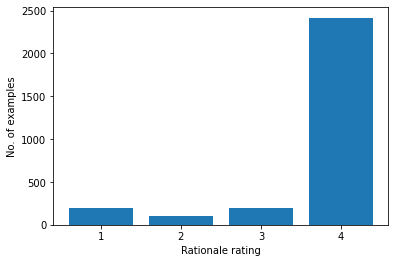

In [18]:
rating_dict = df[df['Operation']!='add']['Rating'].value_counts().to_dict()
rating_dict = dict(sorted(rating_dict.items(), key=lambda item: item[0]))
plt.bar(list(map(str,rating_dict.keys())),rating_dict.values())
plt.xlabel('Rationale rating')
plt.ylabel('No. of examples')
plt.show()

#### Agreement

##### GPT4-generated text

In [68]:
raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_text_only_raelene_cmplt_v2.csv',encoding='UTF-8')
raelene_ann['exmpl_ann_no'] = raelene_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
raelene_ann['SBDH'] = raelene_ann['SBDH'].apply(lambda x: x.lower())
raelene_ann['Annotator'] = 'Raelene'
textspan_match = raelene_ann.apply(lambda x: 1 if x['Textspan'] in x['Text'] else 0, axis=1) # check `Textspan` is a substring from `Text`
assert sum(textspan_match) == len(raelene_ann)
assert raelene_ann['exmpl_ann_no'].nunique() == len(raelene_ann)

emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_text_only_emily_cmplt_v2.csv',encoding='UTF-8')
emily_ann['exmpl_ann_no'] = emily_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
emily_ann['Presence'] = emily_ann['Presence'].apply(lambda x: 'yes' if x=='present' else 'no')
emily_ann['SBDH'] = emily_ann['SBDH'].apply(lambda x: x.lower())
emily_ann['Annotator'] = 'Emily'
textspan_match = emily_ann.apply(lambda x: 1 if x['Textspan'] in x['Text'] else 0, axis=1) # check `Textspan` is a substring from `Text`
assert sum(textspan_match) == len(emily_ann)
assert emily_ann['exmpl_ann_no'].nunique() == len(emily_ann)

adj_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_text_only_adjudicated_v2.csv',encoding='UTF-8')
adj_ann['exmpl_ann_no'] = adj_ann.apply(lambda x:str(x['exmpl_no'])+'-'+str(x['ann_no']),axis=1)
adj_ann['Presence'] = adj_ann['Presence'].apply(lambda x: 'yes' if x=='present' else 'no')
adj_ann['SBDH'] = adj_ann['SBDH'].apply(lambda x: x.lower())
adj_ann['Annotator'] = 'Adjudicated'
textspan_match = adj_ann.apply(lambda x: 1 if x['Textspan'] in x['Text'] else 0, axis=1) # check `Textspan` is a substring from `Text`
assert sum(textspan_match) == len(adj_ann)
assert adj_ann['exmpl_ann_no'].nunique() == len(adj_ann)

gpt4_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_raelene_adj_v2.csv',encoding='UTF-8').iloc[:,:-3].copy()
gpt4_ann = gpt4_ann[gpt4_ann['Annotator']=='GPT-4'].copy()
gpt4_ann = gpt4_ann[gpt4_ann['exmpl_no'].isin(emily_ann['exmpl_no'].unique())].copy()
gpt4_ann['SBDH'] = gpt4_ann['SBDH'].apply(lambda x: x.lower())

In [69]:
print(raelene_ann['SBDH'].unique(), raelene_ann['Presence'].unique(), raelene_ann['Period'].unique())
print(emily_ann['SBDH'].unique(), emily_ann['Presence'].unique(), emily_ann['Period'].unique())
print(adj_ann['SBDH'].unique(), adj_ann['Presence'].unique(), adj_ann['Period'].unique())
print(gpt4_ann['SBDH'].unique(), gpt4_ann['Presence'].unique(), gpt4_ann['Period'].unique())

['job insecurity' 'housing insecurity' 'violence' 'substance abuse'
 'loss of relationship' 'barriers to care' 'pain' 'physical isolation'
 'social isolation' 'food insecurity' 'psychiatric symptoms or disorders'
 'financial insecurity' 'patient disability' 'transitions of care'
 'legal problems'] ['yes' 'no'] ['current' 'unclear' 'history']
['job insecurity' 'housing insecurity' 'violence' 'substance abuse'
 'loss of relationship' 'barriers to care' 'pain' 'physical isolation'
 'social isolation' 'food insecurity' 'psychiatric symptoms or disorders'
 'financial insecurity' 'patient disability' 'transitions of care'
 'legal problems'] ['yes' 'no'] ['current' 'unclear' 'history']
['job insecurity' 'housing insecurity' 'violence' 'substance abuse'
 'loss of relationship' 'barriers to care' 'pain' 'physical isolation'
 'social isolation' 'food insecurity' 'psychiatric symptoms or disorders'
 'financial insecurity' 'patient disability' 'transitions of care'
 'legal problems'] ['yes' 'no'] 

In [70]:
def find_contiguous_overlap(s1, s2):
    words1 = s1.lower().split()
    words2 = s2.lower().split()
    
    max_overlap = []
    
    for i in range(len(words1)):
        for j in range(len(words2)):
            temp_overlap = []
            x, y = i, j
            
            while x < len(words1) and y < len(words2) and words1[x] == words2[y]:
                temp_overlap.append(words1[x])
                x += 1
                y += 1
            
            if len(temp_overlap) > len(max_overlap):
                max_overlap = temp_overlap

    if not max_overlap: return 0
    return len(max_overlap) if (max_overlap[0]==words1[0] or max_overlap[0]==words2[0]) else 0

def get_agreement(df1, df2):
    match, no_match = 0, 0
    match_relaxed = 0
    dis_df = None
    for ex_no in df1['exmpl_no'].unique().tolist():
        temp_df1 = df1[df1['exmpl_no']==ex_no].copy().reset_index(drop=True)[['Textspan', 'SBDH', 'Presence', 'Period']]
        temp_df2 = df2[df2['exmpl_no']==ex_no].copy().reset_index(drop=True)[['Textspan', 'SBDH', 'Presence', 'Period']]
        empty_df = pd.DataFrame([['---'] * len(df1.columns)], columns=df1.columns)
        if not temp_df1.equals(temp_df2):
            match1, match2 = [], []
            relaxed_match1, relaxed_match2 = [], []
            no_match_mapped1, no_match_mapped2 = [], []
            for i in temp_df1.index:
                for j in temp_df2.index:
                    if temp_df1.loc[i].equals(temp_df2.loc[j]):
                        match1 += [i]
                        match2 += [j]
                    # elif temp_df1.loc[i]['Textspan'].lower().strip() in temp_df2.loc[j]['Textspan'].lower().strip() or temp_df2.loc[j]['Textspan'].lower().strip() in temp_df1.loc[i]['Textspan'].lower().strip():
                    elif find_contiguous_overlap(temp_df1.loc[i]['Textspan'].lower().strip(), temp_df2.loc[j]['Textspan'].lower().strip())>0:
                        if temp_df1.loc[i][['SBDH', 'Presence', 'Period']].equals(temp_df2.loc[j][['SBDH', 'Presence', 'Period']]):
                            relaxed_match1 += [i]
                            relaxed_match2 += [j]
                        no_match_mapped1 += [i]
                        no_match_mapped2 += [j]
                        # print(ex_no,i,temp_df1.loc[i]['Textspan'].lower().strip(),'||',temp_df2.loc[j]['Textspan'].lower().strip(),len(no_match_mapped1))
            # if len(match1) == len(match2) == temp_df1.shape[0]:
                # pass
            if len(match1)+len(relaxed_match1) == len(match2)+len(relaxed_match2) == temp_df1.shape[0]:
                pass
            elif len(match1)+len(relaxed_match1)==temp_df1.shape[0]:
                if dis_df is None:
                    dis_df = df2[(df2['exmpl_no']==ex_no)&(~df2['ann_no'].isin(match2+relaxed_match2))].copy()
                else:
                    dis_df = pd.concat([dis_df,df2[(df2['exmpl_no']==ex_no)&(~df2['ann_no'].isin(match2+relaxed_match2))]])
                dis_df = dis_df.append(empty_df, ignore_index=True)
            elif len(match2)+len(relaxed_match2)==temp_df2.shape[0]:
                if dis_df is None:
                    dis_df = df1[(df1['exmpl_no']==ex_no)&(~df1['ann_no'].isin(match1+relaxed_match1))].copy()
                else:
                    dis_df = pd.concat([dis_df,df1[(df1['exmpl_no']==ex_no)&(~df1['ann_no'].isin(match1+relaxed_match1))]])
                dis_df = dis_df.append(empty_df, ignore_index=True)
            else:
                if dis_df is None:
                    dis_df = pd.concat([df1[(df1['exmpl_no']==ex_no)&(~df1['ann_no'].isin(match1+relaxed_match1))],df2[(df2['exmpl_no']==ex_no)&(~df2['ann_no'].isin(match2+relaxed_match2))]])
                else:
                    dis_df = pd.concat([dis_df,df1[(df1['exmpl_no']==ex_no)&(~df1['ann_no'].isin(match1+relaxed_match1))],df2[(df2['exmpl_no']==ex_no)&(~df2['ann_no'].isin(match2+relaxed_match2))]])
                dis_df = dis_df.append(empty_df, ignore_index=True)

            match += len(match1)
            no_match += len(no_match_mapped1)+len(set(range(temp_df1.shape[0]))-set(match1)-set(no_match_mapped1))+len(set(range(temp_df2.shape[0]))-set(match2)-set(no_match_mapped2))
            match_relaxed += len(match1)+len(relaxed_match1)
        else: 
            match  += temp_df1.shape[0]
            match_relaxed += temp_df1.shape[0]

    total_ann = match+no_match
    no_match_relaxed = total_ann - match_relaxed
    print(f'Total annotations: {total_ann}')
    print(f'Matched annotations: {match}({match*100/total_ann:.2f}%)')
    print(f'Unmatched annotations: {no_match}({no_match*100/total_ann:.2f}%)')
    print(f'Matched annotations (Relaxed): {match_relaxed}({match_relaxed*100/total_ann:.2f}%)')
    print(f'Unmatched annotations (Relaxed): {no_match_relaxed}({no_match_relaxed*100/total_ann:.2f}%)')
    return dis_df

print('== Emily-Raelene ==')
dis_df_er = get_agreement(raelene_ann.copy(),emily_ann.copy())
print('== Emily-GPT4 ==')
dis_df_eg = get_agreement(gpt4_ann.copy(),emily_ann.copy())
print('== Raelene-GPT4 ==')
dis_df_rg = get_agreement(raelene_ann.copy(),gpt4_ann.copy())
print('== Adj-GPT4 ==')
dis_df_ag = get_agreement(gpt4_ann.copy(),adj_ann.copy())

== Emily-Raelene ==
Total annotations: 224
Matched annotations: 135(60.27%)
Unmatched annotations: 89(39.73%)
Matched annotations (Relaxed): 181(80.80%)
Unmatched annotations (Relaxed): 43(19.20%)
== Emily-GPT4 ==
Total annotations: 209
Matched annotations: 53(25.36%)
Unmatched annotations: 156(74.64%)
Matched annotations (Relaxed): 133(63.64%)
Unmatched annotations (Relaxed): 76(36.36%)
== Raelene-GPT4 ==
Total annotations: 213
Matched annotations: 48(22.54%)
Unmatched annotations: 165(77.46%)
Matched annotations (Relaxed): 145(68.08%)
Unmatched annotations (Relaxed): 68(31.92%)
== Adj-GPT4 ==
Total annotations: 219
Matched annotations: 56(25.57%)
Unmatched annotations: 163(74.43%)
Matched annotations (Relaxed): 144(65.75%)
Unmatched annotations (Relaxed): 75(34.25%)


In [61]:
# display(HTML(raelene_ann[raelene_ann['exmpl_no']==818].to_html()))
# display(HTML(gpt4_ann[gpt4_ann['exmpl_no']==899].to_html()))

In [60]:
dis_df_eg.iloc[100:,:]

,exmpl_no,ann_no,Annotator,Text,Textspan,SBDH,Presence,Period,Reasoning,Remember,exmpl_ann_no
100,959,0,Emily,He is paralyzed from the waist down and requir...,paralyzed,physical isolation,yes,current,XX,0.0,959-0
101,---,---,---,---,---,---,---,---,---,NaN,NaN
102,---,---,---,---,---,---,---,---,---,NaN,NaN
103,974,1,GPT-4,Unable to secure a new job after getting laid ...,suffering from severe stress,psychiatric symptoms or disorders,yes,current,"Patient is experiencing high levels of stress,...",NaN,NaN
104,974,1,Emily,Unable to secure a new job after getting laid ...,laid off,job insecurity,yes,current,NaN,NaN,974-1
105,---,---,---,---,---,---,---,---,---,NaN,NaN
106,980,0,GPT-4,Patient reports finding it hard to get to her ...,finding it hard to get to her doctor's office,barriers to care,yes,current,Patient having difficulty accessing her health...,NaN,NaN
107,980,0,Emily,Patient reports finding it hard to get to her ...,lack of transportation,barriers to care,yes,current,XX,0.0,980-0
108,---,---,---,---,---,---,---,---,---,NaN,NaN
109,987,0,GPT-4,The patient recently moved into a nursing home...,moved into a nursing home,transitions of care,yes,current,Moving into a nursing home indicates transitio...,NaN,NaN


In [62]:
dis_df_er.to_csv(f'human_eval/synthetic_sbdh_annotation_text_only_adjudication.csv',index=False)

##### GPT-4 generated annotations

In [3]:
df1 = pd.read_csv('human_eval/sbdh_gpt4_v3_test_ann_1_consolidated.csv')
df2 = pd.read_csv('human_eval/sbdh_gpt4_v3_test_ann_2_consolidated.csv')
df1 = df1[df1['ex_no']>=755]
df2 = df2[df2['ex_no']<=999]
assert df1['ex_no'].unique().tolist() == df2['ex_no'].unique().tolist()

In [6]:
match, no_match = 0, 0
match_relaxed = 0
dis_df = None
for ex_no in df1['ex_no'].unique().tolist():
    temp_df1 = df1[df1['ex_no']==ex_no].copy().reset_index(drop=True)[['Text', 'Textspan', 'SBDH', 'Presence', 'Period']]
    temp_df2 = df2[df2['ex_no']==ex_no].copy().reset_index(drop=True)[['Text', 'Textspan', 'SBDH', 'Presence', 'Period']]
    empty_df = pd.DataFrame([['---'] * len(df1.columns)], columns=df1.columns)
    if not temp_df1.equals(temp_df2):
        match1, match2 = [], []
        relaxed_match1, relaxed_match2 = [], []
        no_match_mapped1, no_match_mapped2 = [], []
        for i in temp_df1.index:
            for j in temp_df2.index:
                if temp_df1.loc[i].equals(temp_df2.loc[j]):
                    match1 += [i]
                    match2 += [j]
                elif temp_df1.loc[i]['Textspan'] in temp_df2.loc[j]['Textspan'] or temp_df2.loc[j]['Textspan'] in temp_df1.loc[i]['Textspan']:
                    if temp_df1.loc[i][['SBDH', 'Presence', 'Period']].equals(temp_df2.loc[j][['SBDH', 'Presence', 'Period']]):
                        relaxed_match1 += [i]
                        relaxed_match2 += [j]
                    no_match_mapped1 += [i]
                    no_match_mapped2 += [j]
        if len(match1) == len(match2) == temp_df1.shape[0]:
            pass
        elif len(match1)==temp_df1.shape[0]:
            # display(temp_df2[~temp_df2.index.isin(match2)])
            # display(df2[(df2['ex_no']==ex_no)&(~df2['ann_no'].isin(match2))])
            if dis_df is None:
                dis_df = df2[(df2['ex_no']==ex_no)&(~df2['ann_no'].isin(match2))].copy()
            else:
                dis_df = pd.concat([dis_df,df2[(df2['ex_no']==ex_no)&(~df2['ann_no'].isin(match2))]])
            dis_df = dis_df.append(empty_df, ignore_index=True)
        elif len(match2)==temp_df2.shape[0]:
            # display(temp_df1[~temp_df1.index.isin(match1)])
            # display(df1[(df1['ex_no']==ex_no)&(~df1['ann_no'].isin(match1))])
            if dis_df is None:
                dis_df = df1[(df1['ex_no']==ex_no)&(~df1['ann_no'].isin(match1))].copy()
            else:
                dis_df = pd.concat([dis_df,df1[(df1['ex_no']==ex_no)&(~df1['ann_no'].isin(match1))]])
            dis_df = dis_df.append(empty_df, ignore_index=True)
        else:
            # display(pd.concat([temp_df1[~temp_df1.index.isin(match1)],temp_df2[~temp_df2.index.isin(match2)]]))
            # display(pd.concat([df1[(df1['ex_no']==ex_no)&(~df1['ann_no'].isin(match1))],df2[(df2['ex_no']==ex_no)&(~df2['ann_no'].isin(match2))]]))
            if dis_df is None:
                dis_df = pd.concat([df1[(df1['ex_no']==ex_no)&(~df1['ann_no'].isin(match1))],df2[(df2['ex_no']==ex_no)&(~df2['ann_no'].isin(match2))]])
            else:
                dis_df = pd.concat([dis_df,df1[(df1['ex_no']==ex_no)&(~df1['ann_no'].isin(match1))],df2[(df2['ex_no']==ex_no)&(~df2['ann_no'].isin(match2))]])
            dis_df = dis_df.append(empty_df, ignore_index=True)
        
        match += len(match1)
        no_match += len(no_match_mapped1)+len(set(range(temp_df1.shape[0]))-set(match1)-set(no_match_mapped1))+len(set(range(temp_df2.shape[0]))-set(match2)-set(no_match_mapped2))
        match_relaxed += len(match1)+len(relaxed_match1)
    else: 
        match  += temp_df1.shape[0]
        match_relaxed += temp_df1.shape[0]

In [7]:
# without period
total_ann = match+no_match
no_match_relaxed = total_ann - match_relaxed
print(f'Total annotations: {total_ann}')
print(f'Matched annotations: {match}({match*100/total_ann:.2f}%)')
print(f'Unmatched annotations: {no_match}({no_match*100/total_ann:.2f}%)')
print(f'Matched annotations (Relaxed): {match_relaxed}({match_relaxed*100/total_ann:.2f}%)')
print(f'Unmatched annotations (Relaxed): {no_match_relaxed}({no_match_relaxed*100/total_ann:.2f}%)')

dis_df['Annotator'] = dis_df['Annotator'].apply(lambda x:'Emily' if x=='ann_1' else 'Raelene' if x=='ann_2' else x)
print(dis_df.shape[0])

Total annotations: 527
Matched annotations: 391(74.19%)
Unmatched annotations: 136(25.81%)
Matched annotations (Relaxed): 429(81.40%)
Unmatched annotations (Relaxed): 98(18.60%)
236


In [1504]:
total_ann = match+no_match
no_match_relaxed = total_ann - match_relaxed
print(f'Total annotations: {total_ann}')
print(f'Matched annotations: {match}({match*100/total_ann:.2f}%)')
print(f'Unmatched annotations: {no_match}({no_match*100/total_ann:.2f}%)')
print(f'Matched annotations (Relaxed): {match_relaxed}({match_relaxed*100/total_ann:.2f}%)')
print(f'Unmatched annotations (Relaxed): {no_match_relaxed}({no_match_relaxed*100/total_ann:.2f}%)')

dis_df['Annotator'] = dis_df['Annotator'].apply(lambda x:'Emily' if x=='ann_1' else 'Raelene' if x=='ann_2' else x)
print(dis_df.shape[0])
dis_df

Total annotations: 527
Matched annotations: 372(70.59%)
Unmatched annotations: 155(29.41%)
Matched annotations (Relaxed): 410(77.80%)
Unmatched annotations (Relaxed): 117(22.20%)
288


,ex_no,ann_no,Text,Textspan,SBDH,Presence,Period,Reasoning,Annotator
0,760,1,XXX,XXX,XXX,XXX,XXX,XXX,Emily
1,760,1,Patient has been feeling a deep sense of hopel...,skipping meals due to lack of interest,Psychiatric Symptoms or Disorders,yes,current,Skipping meals due to lack of interest is psyc...,Raelene
2,---,---,---,---,---,---,---,---,---
3,764,0,"Following the death of his wife, the patient r...",death of his wife,Loss of Relationship,yes,unclear,The death of a spouse is considered a loss of ...,Emily
4,764,0,"Following the death of his wife, the patient r...",death of his wife,Loss of Relationship,yes,history,The death of a spouse is considered a loss of ...,Raelene
...,...,...,...,...,...,...,...,...,...
283,998,0,The Veteran reports having nightmares of comba...,nightmares of combat,Psychiatric Symptoms or Disorders,yes,current,"The patient reports nightmares of combat, indi...",Emily
284,998,0,The Veteran reports having nightmares of comba...,nightmares,Psychiatric Symptoms or Disorders,yes,current,"The patient reports nightmares of combat, indi...",Raelene
285,---,---,---,---,---,---,---,---,---
286,999,1,"Recently, patient was discharged from the hosp...",home,Housing Insecurity,no,current,Having a home indicates lack of housing insecu...,Emily


In [1570]:
dis_df.to_csv(f'human_eval/sbdh_gpt4_v3_test_adjudicaion.csv',index=False)

In [1577]:
# Agreement || RATIONALE
raelene_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_raelene_cmplt.csv',encoding='UTF-8')
emily_ann = pd.read_csv('human_eval/synthetic_sbdh_annotation_emily_cmplt.csv',encoding='UTF-8')
ann_1_rating = raelene_ann[(raelene_ann['exmpl_no']<=999)&(raelene_ann['Annotator']=='GPT-4')]['Rationale_rating'].to_numpy()
ann_2_rating = emily_ann[(emily_ann['exmpl_no']>=755)&(emily_ann['Annotator']=='GPT-4')]['Rationale_rating'].to_numpy()

print(f"Cohen's Kappa: {cohen_kappa_score(ann_1_rating, ann_2_rating):.2f}")
print(f"Percentage agreement: {sum(np.array(ann_1_rating)==np.array(ann_2_rating))*100/len(ann_2_rating):.2f}")

from numpy import corrcoef
print(f"Pearson's corrleation: {corrcoef([ann_1_rating,ann_2_rating])[0,1]:.2f}")

Cohen's Kappa: 0.37
Percentage agreement: 83.29
Pearson's corrleation: 0.61


#### LLM Agreement

In [1672]:
with open('synth_data_gpt4/synth_data_aio_filtered_8767_MSF_1_updated.json') as f: # unfortunately 34 annotations' `Corrected_Reasoning` and `Correct` fields were missing in the previous file
    llm_eval_data = json.load(f)

In [1673]:
num_train_examples = int(len(llm_eval_data)*.7)
num_val_examples = int(len(llm_eval_data)*.1)
num_test_examples = len(llm_eval_data) - num_train_examples - num_val_examples

random.seed(0)
random.shuffle(llm_eval_data)
anns = []
for idx,i in enumerate(llm_eval_data[-num_test_examples:]):
    for ann_idx,_ in enumerate(i['Annotations']):
        ann = i['Annotations'][ann_idx].copy()
        ann['ex_no'] = idx
        ann['ann_no'] = ann_idx
        anns += [ann]
print(f'Total examples: {num_test_examples:,}; total annotations: {len(anns):,}')
anns_df = pd.DataFrame(anns)

Total examples: 1,755; total annotations: 2,897


In [1675]:
anns_df['Correct'] = anns_df['Correct'].apply(lambda x:x.lower())
anns_df['Correct'].value_counts(normalize=True)

yes    0.907836
no     0.092164
Name: Correct, dtype: float64

In [1676]:
anns_df.head()

,Textspan,Reasoning,SBDH,Presence,Period,Text,idx,Correct,Corrected_Reasoning,ex_no,ann_no
0,lower back pain,Experiencing lower back pain is a sign of the ...,Pain,yes,current,His lower back pain has been worsening over th...,12819,yes,The text clearly mentions that the patient is ...,0,0
1,recently been laid off,"The patient lost his job recently, indicating ...",Job Insecurity,yes,current,The patient has recently been laid off from hi...,947,yes,The patient losing his job is a clear indicati...,1,0
2,concern about his financial situation,The patient is worried about his financial sit...,Financial Insecurity,yes,current,The patient has recently been laid off from hi...,947,yes,The patient is worried about his financial sit...,1,1
3,difficult to travel to the clinic,Difficulty in traveling to the clinic due to l...,Barriers to Care,yes,current,Patient finds it difficult to travel to the cl...,3924,yes,The textspan indicates that the patient faces ...,2,0
4,going through a divorce,Divorce is a loss of a personal relationship.,Loss of Relationship,yes,current,Veteran is going through a divorce and his wif...,609,yes,The text clearly mentions that the veteran is ...,3,0


#### Prepare adj. data in BIO+DSS+MLC format

In [56]:
def is_nested(range1list:list, range2list:list, verbose=False):
    '''
    Find if there is an intersection between elements in range1list and range2list.
    '''
    if len(range1list)==0 or len(range2list)==0: return False
    for range2 in range2list:
        for range1 in range1list:
            if set(range(*range1)).intersection(set(range(*range2))):
                if verbose:print(range1,range2)
                return True
    return False

def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll))

    return results

split = 'val' # <<< CHECK THIS BEFORE EXECUTING THE CELL ⚠️

# merge annotations into single row
df = pd.read_csv(f'human_eval/sbdh_gpt4_v3_{split}_cmbd_consolidated.csv')
df = df[df['Operation']!='discard'].copy() # remove unnecessary annotations
df['Presence'] = df['Presence'].apply(lambda x: x if x=='yes' else 'not_yes')
df['Period'] = df['Period'].apply(lambda x: x if x=='current' else 'not_current')

anns_df_collapsed = pd.DataFrame(df['ex_no'].unique(),columns=['idx']).copy()
for col in ['Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period', 'Text']: 
    anns_df_collapsed[col] = 0
    
for i,idx in tqdm(enumerate(df['ex_no'].unique()),total=anns_df_collapsed.shape[0]):
    temp_df = df[df['ex_no']==idx].copy()
    assert temp_df['Text'].nunique()==1
    for col in ['Textspan', 'Reasoning', 'SBDH', 'Presence', 'Period']:
        assert 'XXX' not in temp_df[col].tolist()
        anns_df_collapsed.loc[i,col] = ' || '.join(map(str.lower,temp_df[col].tolist()))
    anns_df_collapsed.loc[i,'Text'] = temp_df.iloc[0]['Text']

anns_df_collapsed = pd.DataFrame(anns_df_collapsed)
anns_df_collapsed

  0%|          | 0/862 [00:00<?, ?it/s]

,idx,Textspan,Reasoning,SBDH,Presence,Period,Text
0,0,history of substance abuse || enrolled in a su...,- || - || the patient has a history of opioid ...,substance abuse || substance abuse || substanc...,yes || yes || yes,not_current || current || not_current,"Patient has a history of substance abuse, spec..."
1,1,currently on parole || parole officer,- || having a parole officer indicates legal p...,legal problems || legal problems,yes || yes,current || current,Patient is currently on parole and has to meet...
2,2,has been living in a shelter,-,housing insecurity,yes,current,"Over the past few months, the patient has been..."
3,3,severe headaches,-,pain,yes,current,Patient is experiencing severe headaches and h...
4,4,facing possible jail time || possession of ill...,- || possession of illegal substances indicate...,legal problems || legal problems,yes || yes,current || current,He's facing possible jail time for possession ...
...,...,...,...,...,...,...,...
857,871,denies any current or past substance abuse || ...,- || - || denial of past substance abuse indic...,substance abuse || food insecurity || substanc...,not_yes || not_yes || not_yes,current || current || not_current,Patient denies any current or past substance a...
858,872,struggles to provide food || struggles to prov...,- || struggling to provide food and necessitie...,food insecurity || financial insecurity || soc...,yes || yes || yes,current || current || current,She is a single mother of three and struggles ...
859,873,feeling down || isolated || divorce,feeling down indicates presence of psychiatric...,psychiatric symptoms or disorders || social is...,yes || yes || yes,current || current || not_current,Patient reports that she has been feeling down...
860,874,feels lonely and isolated || avoids social int...,- || -,social isolation || social isolation,yes || yes,current || current,"Patient often feels lonely and isolated, and a..."


In [57]:
# NER, BIO format
bio_formatted_data = []
for row_id in tqdm(range(anns_df_collapsed.shape[0])):
    temp_dict = {}
    text = word_tokenize(anns_df_collapsed.iloc[row_id]['Text'])
    temp_dict['tokens'] = text
    text_sbdh_tags = ['O']*len(text)
    text_presence_tags = ['O']*len(text)
    text_period_tags = ['O']*len(text)

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = anns_df_collapsed.iloc[row_id]['Presence'].split(' || ')
    period_tags = anns_df_collapsed.iloc[row_id]['Period'].split(' || ')
    
    all_sl_idxs = []
    for i,span in enumerate(anns_df_collapsed.iloc[row_id]['Textspan'].split(' || ')):
        textspan = word_tokenize(span)
        sl_idxs = find_sub_list(textspan,text) 
        for idx in sl_idxs:
            if text_sbdh_tags[idx[0]:idx[1]] == ['O']*len(textspan): # only put labels if the tokens are already unlabeled; avoiding nested labels
                text_sbdh_tags[idx[0]] = 'B-'+sbdh_tags[i]
                text_sbdh_tags[idx[0]+1:idx[1]] = ['I-'+sbdh_tags[i]]*(len(textspan)-1)
                text_presence_tags[idx[0]] = 'B-'+presence_tags[i]
                text_presence_tags[idx[0]+1:idx[1]] = ['I-'+presence_tags[i]]*(len(textspan)-1)
                text_period_tags[idx[0]] = 'B-'+period_tags[i]
                text_period_tags[idx[0]+1:idx[1]] = ['I-'+period_tags[i]]*(len(textspan)-1)
                all_sl_idxs += [idx]
    
    if len(all_sl_idxs)>1:
        for idx1, idx2 in zip(all_sl_idxs[:-1],all_sl_idxs[1:]):
            if set(range(*idx1)).intersection(set(range(*idx2))): 
                print(f'Testspan overlap found at {row_id}!')
                break
            
    # print(text)
    temp_dict['ner_tags'] = text_sbdh_tags
    temp_dict['presence_tags'] = text_presence_tags
    temp_dict['period_tags'] = text_period_tags
    bio_formatted_data += [temp_dict]
    
with open(f'synth_data_gpt4/synth_data_aio_BIO_{split}_hr.json','w') as f:
    json.dump({'data':bio_formatted_data}, f)
print(bio_formatted_data[:3])

  0%|          | 0/862 [00:00<?, ?it/s]

[{'tokens': ['Patient', 'has', 'a', 'history', 'of', 'substance', 'abuse', ',', 'specifically', 'opioid', 'misuse', '.', 'He', 'is', 'currently', 'enrolled', 'in', 'a', 'substance', 'abuse', 'treatment', 'program', '.'], 'ner_tags': ['O', 'O', 'O', 'B-substance_abuse', 'I-substance_abuse', 'I-substance_abuse', 'I-substance_abuse', 'O', 'O', 'B-substance_abuse', 'I-substance_abuse', 'O', 'O', 'O', 'O', 'B-substance_abuse', 'I-substance_abuse', 'I-substance_abuse', 'I-substance_abuse', 'I-substance_abuse', 'I-substance_abuse', 'I-substance_abuse', 'O'], 'presence_tags': ['O', 'O', 'O', 'B-yes', 'I-yes', 'I-yes', 'I-yes', 'O', 'O', 'B-yes', 'I-yes', 'O', 'O', 'O', 'O', 'B-yes', 'I-yes', 'I-yes', 'I-yes', 'I-yes', 'I-yes', 'I-yes', 'O'], 'period_tags': ['O', 'O', 'O', 'B-not_current', 'I-not_current', 'I-not_current', 'I-not_current', 'O', 'O', 'B-not_current', 'I-not_current', 'O', 'O', 'O', 'O', 'B-current', 'I-current', 'I-current', 'I-current', 'I-current', 'I-current', 'I-current', 'O

In [58]:
# DSS
formatted_data = []
skip_count, total_ann_count = 0, 0
for row_id in tqdm(range(anns_df_collapsed.shape[0])):
    temp_dict = {}
    temp_dict['text'] = anns_df_collapsed.iloc[row_id]['Text']

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = [i for i in anns_df_collapsed.iloc[row_id]['Presence'].split(' || ')]
    period_tags = [i for i in anns_df_collapsed.iloc[row_id]['Period'].split(' || ')]
    reasoning_tags = [i for i in anns_df_collapsed.iloc[row_id]['Reasoning'].split(' || ')]
    # temp_dict['reasoning'] = anns_df_collapsed.iloc[row_id]['Reasoning'].replace(' || ',' ')
    sbdh_ann, period_ann, reasoning_ann = [], [], []
    
    textspan_indices = []
    for i,textspan in enumerate(anns_df_collapsed.iloc[row_id]['Textspan'].split(' || ')):
        total_ann_count += 1
        if presence_tags[i] == 'yes': # only consider presence=yes
            sl_indices = find_sub_list(textspan,temp_dict['text'])
            if is_nested(textspan_indices,sl_indices): # check for nested annotations and skip if found any
                skip_count += 1
                continue 
            textspan_indices += sl_indices
            sbdh_ann += [textspan+' <'+sbdh_tags[i]+'>']
            period_ann += [textspan+' <'+period_tags[i]+'>']
            reasoning_ann += [reasoning_tags[i]]
    temp_dict['sbdh_ann'] = ', '.join(sbdh_ann)
    temp_dict['period_ann'] = ', '.join(period_ann)
    temp_dict['reasoning'] = ' '.join(reasoning_ann)
    formatted_data += [temp_dict]
    # if row_id==10: break
print(f'Skipped annotations: {skip_count}, out of {total_ann_count}')  

with open(f'synth_data_gpt4/sbdh_gpt4_v3_{split}_hr.json','w') as f:
    json.dump({'data':formatted_data}, f)
formatted_data[:3]

  0%|          | 0/862 [00:00<?, ?it/s]

Skipped annotations: 45, out of 1625


[{'text': 'Patient has a history of substance abuse, specifically opioid misuse. He is currently enrolled in a substance abuse treatment program.',
  'sbdh_ann': 'history of substance abuse <substance_abuse>, enrolled in a substance abuse treatment program <substance_abuse>, opioid misuse <substance_abuse>',
  'period_ann': 'history of substance abuse <not_current>, enrolled in a substance abuse treatment program <current>, opioid misuse <not_current>',
  'reasoning': '- - the patient has a history of opioid misuse, which is substance abuse.'},
 {'text': 'Patient is currently on parole and has to meet with his parole officer bi-weekly.',
  'sbdh_ann': 'currently on parole <legal_problems>, parole officer <legal_problems>',
  'period_ann': 'currently on parole <current>, parole officer <current>',
  'reasoning': '- having a parole officer indicates legal problems.'},
 {'text': 'Over the past few months, the patient has been living in a shelter.',
  'sbdh_ann': 'has been living in a shel

In [59]:
# MLC
formatted_data = []
total_ann_count = 0
for row_id in tqdm(range(anns_df_collapsed.shape[0])):
    temp_dict = {}
    temp_dict['text'] = anns_df_collapsed.iloc[row_id]['Text']

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = anns_df_collapsed.iloc[row_id]['Presence'].split(' || ')
    reasoning_tags = anns_df_collapsed.iloc[row_id]['Reasoning'].split(' || ')
    
    for sbdh in set(sbdh_map_dict.values()):
        temp_dict['label_'+sbdh.replace(' ','_')] = 0
    
    sbdh_ann, reasoning_ann, textspan_indices = [], [], []
    for i,_ in enumerate(presence_tags):
        total_ann_count += 1
        if presence_tags[i] == 'yes': # only consider presence=yes
            temp_dict['label_'+sbdh_tags[i]] = 1
            sbdh_ann += ['<'+sbdh_tags[i]+'>']
            reasoning_ann += [reasoning_tags[i]]
    temp_dict['sbdh_ann'] = ', '.join(set(sbdh_ann))
    temp_dict['reasoning'] = ' '.join(reasoning_ann)
    formatted_data += [temp_dict]
print(f'Total annotations: {total_ann_count}')   

with open(f'synth_data_gpt4/sbdh_gpt4_v3_multilabel_hr_{split}.json','w') as f:
    json.dump({'data':formatted_data}, f)
formatted_data[:3]

  0%|          | 0/862 [00:00<?, ?it/s]

Total annotations: 1625


[{'text': 'Patient has a history of substance abuse, specifically opioid misuse. He is currently enrolled in a substance abuse treatment program.',
  'label_barriers_to_care': 0,
  'label_financial_insecurity': 0,
  'label_patient_disability': 0,
  'label_isolation_or_loss_of_relationship': 0,
  'label_psychiatric_symptoms_or_disorders': 0,
  'label_substance_abuse': 1,
  'label_food_insecurity': 0,
  'label_violence': 0,
  'label_housing_insecurity': 0,
  'label_pain': 0,
  'label_legal_problems': 0,
  'label_transitions_of_care': 0,
  'sbdh_ann': '<substance_abuse>',
  'reasoning': '- - the patient has a history of opioid misuse, which is substance abuse.'},
 {'text': 'Patient is currently on parole and has to meet with his parole officer bi-weekly.',
  'label_barriers_to_care': 0,
  'label_financial_insecurity': 0,
  'label_patient_disability': 0,
  'label_isolation_or_loss_of_relationship': 0,
  'label_psychiatric_symptoms_or_disorders': 0,
  'label_substance_abuse': 0,
  'label_fo

#### Convert to multi-label classification format

In [413]:
formatted_data = []
total_ann_count = 0
for row_id in tqdm(range(anns_df_collapsed.shape[0])):
    temp_dict = {}
    temp_dict['ex_no'] = anns_df_collapsed.iloc[row_id]['ex_no']
    temp_dict['text'] = anns_df_collapsed.iloc[row_id]['Text']

    sbdh_tags = [sbdh_map_dict[i].replace(' ','_') for i in anns_df_collapsed.iloc[row_id]['SBDH'].split(' || ')]
    presence_tags = anns_df_collapsed.iloc[row_id]['Presence'].split(' || ')
    # temp_dict['reasoning'] = anns_df_collapsed.iloc[row_id]['Corrected_Reasoning'].replace(' || ',' ')
    reasoning_tags = [i for i in anns_df_collapsed.iloc[row_id]['Corrected_Reasoning'].split(' || ')]
    
    for sbdh in set(sbdh_map_dict.values()):
        temp_dict['label_'+sbdh.replace(' ','_')] = 0
    
    sbdh_ann, reasoning_ann, textspan_indices = [], [], []
    for i,_ in enumerate(presence_tags):
        total_ann_count += 1
        if presence_tags[i] == 'yes': # only consider presence=yes
            temp_dict['label_'+sbdh_tags[i]] = 1
            sbdh_ann += ['<'+sbdh_tags[i]+'>']
            reasoning_ann += [reasoning_tags[i]]
    temp_dict['sbdh_ann'] = ', '.join(set(sbdh_ann))
    temp_dict['reasoning'] = ' '.join(reasoning_ann)
    formatted_data += [temp_dict]
print(f'Total annotations: {total_ann_count}')   

  0%|          | 0/8518 [00:00<?, ?it/s]

Total annotations: 13094


In [414]:
formatted_data[1331]

{'ex_no': 1363,
 'text': 'The patient, currently in jail, has mentioned feeling alone and isolated.',
 'label_barriers_to_care': 0,
 'label_substance_abuse': 0,
 'label_housing_insecurity': 0,
 'label_patient_disability': 0,
 'label_legal_problems': 1,
 'label_food_insecurity': 0,
 'label_transitions_of_care': 0,
 'label_psychiatric_symptoms_or_disorders': 0,
 'label_isolation_or_loss_of_relationship': 1,
 'label_violence': 0,
 'label_pain': 0,
 'label_financial_insecurity': 0,
 'sbdh_ann': '<isolation_or_loss_of_relationship>, <legal_problems>',
 'reasoning': 'The patient is currently in jail which is a sign of legal problems. As per the text, the patient currently feels alone and isolated, which correctly represents a case of Social Isolation.'}

In [420]:
ml_sbdh_cols = [
    'label_barriers_to_care', 'label_substance_abuse', 'label_housing_insecurity', 'label_financial_insecurity', 'label_psychiatric_symptoms_or_disorders',
    'label_isolation_or_loss_of_relationship', 'label_patient_disability', 'label_violence', 'label_legal_problems', 'label_transitions_of_care', 'label_pain', 'label_food_insecurity'
]
print(pd.DataFrame(formatted_data)[ml_sbdh_cols].sum(axis=0))
print(len(formatted_data))

label_barriers_to_care                      436
label_substance_abuse                       818
label_housing_insecurity                    804
label_financial_insecurity                 1889
label_psychiatric_symptoms_or_disorders    1343
label_isolation_or_loss_of_relationship    1948
label_patient_disability                    765
label_violence                              614
label_legal_problems                        444
label_transitions_of_care                   621
label_pain                                  866
label_food_insecurity                       645
dtype: int64
8518


In [421]:
# v3: reordered according to aio data, corrected 'reasoning' field, v2 has erroneous (nested/presece=No) reasonings
num_train_examples = int(len(synth_sbdh_data_filtered)*.7)
num_val_examples = int(len(synth_sbdh_data_filtered)*.1)
num_test_examples = len(synth_sbdh_data_filtered) - num_train_examples - num_val_examples
print(num_train_examples, num_val_examples, num_test_examples)

exmpl_order = list(range(len(synth_sbdh_data_filtered)))
random.seed(0)
random.shuffle(exmpl_order)

df = pd.DataFrame(formatted_data)
df.index=df['ex_no']

with open('synth_data_gpt4/sbdh_gpt4_msf_v3_multilabel_train.json','w') as f:
    new_order = [i for i in exmpl_order[:num_train_examples] if i in df['ex_no'].tolist()]
    json.dump({'data':df.loc[new_order].to_dict(orient='records')}, f)
    print(len(new_order))
with open('synth_data_gpt4/sbdh_gpt4_msf_v3_multilabel_valid.json','w') as f:
    new_order = [i for i in exmpl_order[num_train_examples:num_train_examples+num_val_examples] if i in df['ex_no'].tolist()]
    json.dump({'data':df.loc[new_order].to_dict(orient='records')}, f)
    print(len(new_order))
with open('synth_data_gpt4/sbdh_gpt4_msf_v3_multilabel_test.json','w') as f:
    new_order = [i for i in exmpl_order[-num_test_examples:] if i in df['ex_no'].tolist()]
    json.dump({'data':df.loc[new_order].to_dict(orient='records')}, f)
    print(len(new_order))

6136 876 1755
5965
854
1699
